# 6_Summary

In this notebook, I will load the results produced in ipynb 1-5, and then proceed with visualization and discussion.

Outline
- Data Prep
- Functions
- Sentiment Analysis
    - 1. Overall
    - 2. Topic
    - 3. Organization
    - 4. Product
    - 5. Location
    - 6. Person
    - 7. Industry
    - 8. Job
    - 9. Technology
    - 10. New Technology

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import ast
from sklearn.preprocessing import StandardScaler
import wordcloud
import re

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.simplefilter('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Data Prep

### Read data from previous results

In [2]:
%%time

# Document base
df_cleaned = pd.read_parquet('cleaned_data.parquet', engine='pyarrow')
df_topic = pd.read_parquet('topicmodeling.parquet', engine='pyarrow')

# Sentence base
df_sentence = pd.read_parquet('sentence.parquet', engine='pyarrow')
df_entities = pd.read_parquet('entities.parquet', engine='pyarrow')
df_entities_manual = pd.read_parquet('entities_manual.parquet', engine='pyarrow')
df_sentiment = pd.read_parquet('sentiment.parquet', engine='pyarrow')

CPU times: user 13 s, sys: 7.75 s, total: 20.8 s
Wall time: 24.6 s


In [3]:
df_cleaned.head()

doc_id  \
0       1   
1       2   
4       3   
5       4   
8       5   

                                                                                                                                                                                url  \
0  http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/   
1                                          http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/   
4                                                                  http://www.millenniumpost.in/big-stories/ai-express-aircraft-skids-off-runaway-in-kozhikode-rescue-ops-on-414926   
5                                                                                                                             http://www.nativestew.com/2023/11/ai-took-my-job.html   
8                   http://www.sbwire.com/press-releases/healthcare-artificial-intelligence-market-next-big-thing-major-giants-general-electric-medtronic-aicure-apixio-1363690.htm   

         date language  \
0  2020-02-26       en   
1  2020-02-27       en   
4  2020-08-07       en   
5  2023-11-20       en   
8  2022-10-06       en   

                                                                                                                                                     title  \
0  LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis   
1                                       Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament   
4                                                                                                Two dead as AI Express flight skids off Kozhikode airport   
5                                                                                                Native Stew - Bahamas AI Art Photos Videos AI Took My Job   
8                                                                         Healthcare Artificial Intelligence Market Analysis and Forecast for Next 5 Years   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
0  LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc. Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Mach...   
1  Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament Skip to content Thursday February 27 2020 Latest Mansplaining in conferences How can we get him to forestall Drax power station to cease burning coal in March 2021 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy Coronavirus Dettol sales surge as markets fall again Levi Strauss marks the next phase in corporate paid leave policies News Parliament Get the Real...   
4  Two dead as AI Express flight skids off Kozhikode airportTopLoginSubscribeToggle navigationFeaturesDelhiKolkataNationOpinionEditorialBusinessSportsSunday PostBeyond BygoneEpic PowerIn RetrospectGlob

In [4]:
df_cleaned.shape

(157054, 7)

In [5]:
df_topic.head()

doc_id           topic
0       1  MarketResearch
1       2      HealthCare
2       3           other
3       4           other
4       5  MarketResearch

In [6]:
df_topic.shape

(157054, 2)

In [7]:
df_sentence.head()

doc_id  sentence_id  \
0       1            1   
1       1            2   
2       1            3   
3       1            4   
4       1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LegalTech Artificial Intelligence Market 2019  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                Technology Advancement and Future Scope Casetext Inc.  
2  Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026 Apollo Games Sony Aristocrat Leisure IGT Infectio...  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Catalyst Repository Systems eBREVIA  
4                                                                                                                                                                                                                                                                                                                                                                                                      General NewsLegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc.

In [8]:
df_sentence.shape

(7068447, 3)

In [9]:
df_entities.head()

doc_id  sentence_id  \
0       1            1   
1       1            2   
2       1            3   
3       1            4   
4       1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              entities  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [[LegalTech, ORG]]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                       [[Technology Advancement and Future Scope Casetext Inc., ORG]]  
2  [[Catalyst Repository Systems, ORG], [Wednesday February 26 2020, DATE], [Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights, EVENT], [2020-2026, DATE], [Apollo Games, ORG], [Sony, ORG], [Aristocrat, NORP], [Leisure IGT Infectious Disease Testing Using PCR, ORG], [Optotechn...  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [[Catalyst Repository Systems, ORG]]  
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [[NewsLegalTech, PERSON]]

In [10]:
df_entities.shape

(7068447, 3)

In [11]:
df_entities_manual.head()

doc_id  sentence_id                                   entities_manual
0       1            1                                                []
1       1            2                                                []
2       1            3  [[Game, IND], [Healthcare, IND], [Leisure, IND]]
3       1            4                                                []
4       1            5                                                []

In [12]:
df_entities_manual.shape

(7068447, 3)

In [13]:
df_sentiment.head()

doc_id  sentence_id  sentiment_score sentiment
0       1            1           0.4767  positive
1       1            2           0.0000   neutral
2       1            3           0.9349  positive
3       1            4           0.0000   neutral
4       1            5           0.4767  positive

In [14]:
df_sentiment.shape

(7068447, 4)

### Marge dataframe

In [15]:
# Merging df_sentence with df_entities on 'doc_id' and 'sentence_id'
df_merged = df_sentence.merge(df_entities, on=['doc_id', 'sentence_id'], how='left')

# Merging df_sentence with df_entities_manual on 'doc_id' and 'sentence_id'
df_merged = df_merged.merge(df_entities_manual, on=['doc_id', 'sentence_id'], how='left')

# Merging the result with df_sentiment on 'doc_id' and 'sentence_id'
df_merged = df_merged.merge(df_sentiment, on=['doc_id', 'sentence_id'], how='left')

df_merged.head()

doc_id  sentence_id  \
0       1            1   
1       1            2   
2       1            3   
3       1            4   
4       1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LegalTech Artificial Intelligence Market 2019   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                Technology Advancement and Future Scope Casetext Inc.   
2  Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026 Apollo Games Sony Aristocrat Leisure IGT Infectio...   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Catalyst Repository Systems eBREVIA   
4                                                                                                                                                                                                                                                                                                                                                                                                      General NewsLegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              entities  \
0                                                                                                                                                                                                                                                                                                              

In [16]:
df_merged.shape

(7068447, 7)

In [17]:
# Merging df_merged with df_topic on 'doc_id' to add 'topic'
df_merged = df_merged.merge(df_topic[['doc_id', 'topic']], on='doc_id', how='left')

# Merging df_merged with df_cleaned to add 'date'
df_merged = df_merged.merge(df_cleaned[['doc_id', 'date']], on='doc_id', how='left')

In [18]:
df_merged.head()

doc_id  sentence_id  \
0       1            1   
1       1            2   
2       1            3   
3       1            4   
4       1            5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              sentence  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                        LegalTech Artificial Intelligence Market 2019   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                Technology Advancement and Future Scope Casetext Inc.   
2  Catalyst Repository Systems eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech Wednesday February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries BD Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026 Apollo Games Sony Aristocrat Leisure IGT Infectio...   
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Catalyst Repository Systems eBREVIA   
4                                                                                                                                                                                                                                                                                                                                                                                                      General NewsLegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              entities  \
0                                                                                                                                                                                                                                                                                                              

In [19]:
df_merged.shape

(7068447, 9)

In [20]:
# Exclude topic = 'other' for meaningful analysis
df_merged = df_merged[df_merged['topic']!='other']

# Functions

In [21]:
def plot_sentiment_over_time(df, period_col, sentiment_col, aggregation_methods, category_col=None):
    """
    Plots the sentiment score over time for specified categories or overall if no category is specified.
    Supports multiple aggregation methods.

    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    period_col (str): Column name containing the time periods.
    sentiment_col (str): Column name containing the sentiment scores.
    aggregation_methods (list): List of aggregation methods to apply (e.g., 'mean', 'sum', 'count').
    category_col (str, optional): Column name representing the categories to group by (e.g., 'topic', 'entity'). Defaults to None.
    """
    plt.figure(figsize=(14, 8))
    for agg_method in aggregation_methods:
        if agg_method not in ['mean', 'sum', 'count']:
            continue
        if category_col:
            agg_data = df.groupby([category_col, period_col])[sentiment_col].agg(agg_method).reset_index()
            for category in agg_data[category_col].unique():
                category_data = agg_data[agg_data[category_col] == category]
                plt.plot(category_data[period_col], category_data[sentiment_col], label=f'{agg_method} of {category}')
        else:
            agg_data = df.groupby(period_col)[sentiment_col].agg(agg_method).reset_index()
            plt.plot(agg_data[period_col], agg_data[sentiment_col], label=f'{agg_method} {sentiment_col}')

    plt.xticks(rotation=45)
    plt.xlabel('Time Period')
    plt.ylabel('Sentiment Score')
    plt.title('Sentiment Score Over Time')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [22]:
def filter_rows_by_words(df, column, words):
    """
    Filters the DataFrame rows based on the presence of specified words in a given column.

    Args:
        df (pd.DataFrame): The DataFrame to filter.
        column (str): The name of the column to search for the words.
        words (list): A list of words to search for in the specified column.

    Returns:
        pd.DataFrame: A DataFrame containing only the rows where the specified column
                      contains any of the words in the list.
    """
    # Create a regex pattern to match any of the words in the list
    pattern = '|'.join(words)
    # Use str.contains to filter rows, case insensitive
    filtered_df = df[df[column].str.contains(pattern, case=False, na=False)]
    return filtered_df

In [23]:
def plot_sentiment_heatmap(df, period_col, sentiment_col, category_col, aggregation='mean'):
    """
    Plots a heatmap of sentiment scores over time for different categories based on a specified aggregation method.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    period_col (str): Column name for the period (e.g., 'year_month').
    sentiment_col (str): Column name for the sentiment score.
    category_col (str): Column name representing the categories to group by (e.g., 'topic', 'entity').
    aggregation (str): Aggregation method to use ('mean', 'sum', 'count').

    Returns:
    None: Displays a heatmap.
    """
    sentiment_matrix = df.pivot_table(index=category_col, columns=period_col, values=sentiment_col, aggfunc=aggregation)
    plt.figure(figsize=(14, 8))
    # sns.heatmap(sentiment_matrix, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={'label': f'{aggregation.title()} Sentiment Score'})
    sns.heatmap(sentiment_matrix, annot=False, cmap="coolwarm", cbar_kws={'label': f'{aggregation.title()} Sentiment Score'})
    plt.title(f"{aggregation.title()} Sentiment Score Heatmap")
    plt.ylabel(category_col.capitalize())
    plt.xlabel('Time Period')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [24]:
def plot_sentiment_by_category(df, category_col, sentiment_col, aggregation='mean'):
    """
    Plots a horizontal bar chart of aggregated sentiment scores by category using specified aggregation.

    Args:
    df (pd.DataFrame): DataFrame containing the data.
    category_col (str): Column name representing the categories to analyze.
    sentiment_col (str): Column name for the sentiment scores.
    aggregation (str): Aggregation method ('mean', 'sum', 'count').

    Returns:
    None: Displays a horizontal bar chart.
    """
    agg_data = df.groupby(category_col)[sentiment_col].agg(aggregation).sort_values(ascending=True)
    plt.figure(figsize=(10, 8))
    agg_data.plot(kind='barh')
    plt.title(f'{aggregation.capitalize()} Sentiment Score by {category_col.capitalize()}')
    plt.xlabel(f'{aggregation.capitalize()} Sentiment Score')
    plt.ylabel(category_col.capitalize())
    plt.tight_layout()
    plt.show()

In [25]:
# Count entities by type and return a DataFrame showing the top N entities for each specified type
def count_top_entities(entities_series, entity_types, top_n):
    """
    Count top N entities for specified entity types in a series of entity lists and return the counts in table format.
    :param entities_series: Pandas Series containing lists of entities (tuples of entity text and entity type)
    :param entity_types: List of entity types to count (e.g., ['ORG', 'PRODUCT', 'GPE', 'PERSON'])
    :param top_n: Number of top entities to display for each type
    :return: DataFrame showing the top N entities for each specified type
    """
    counters = {entity_type: Counter() for entity_type in entity_types}
    
    # Iterate over the series to count entities by type
    for entities in entities_series:
        for entity_text, entity_type in entities:
            if entity_type in entity_types:
                counters[entity_type][entity_text] += 1
    
    # Prepare the DataFrame to display the top N entities for each type, filling in missing values
    top_entities_df = pd.DataFrame()
    for entity_type in entity_types:
        top_entities = counters[entity_type].most_common(top_n)
        # Ensure the list has a length of top_n by appending empty strings if necessary
        top_entities += [("", 0)] * (top_n - len(top_entities))
        top_entities_df[entity_type] = [f"{entity[0]} ({entity[1]})" if entity[0] else "" for entity in top_entities]
    
    return top_entities_df

In [26]:
def plot_top_worst_entities(df, entity_col, sentiment_col, aggregation, entity_types, exclude_entities, top_n, min_count):
    """
    Plots the top and worst entities based on their aggregated sentiment scores,
    considering specified entity types and excluding certain entities.

    Args:
        df (pd.DataFrame): DataFrame containing entities and sentiment scores.
        entity_col (str): Column name containing entities in list of lists format.
        sentiment_col (str): Column name containing sentiment scores.
        aggregation (str): Aggregation method ('mean', 'sum', 'count').
        entity_types (list): List of entity types to include.
        exclude_entities (list): List of entity names to exclude.
        top_n (int): Number of top and worst entities to display.
        min_count (int): Minimum count for an entity to be included.
    """
    # Initialize containers for entity scores and counts
    entity_scores = defaultdict(list)

    # Process each entity in each row
    for _, row in df.iterrows():
        entities = row[entity_col]
        sentiment_score = row[sentiment_col]
        for entity in entities:
            entity_name, entity_type = entity[0], entity[1]
            if entity_type in entity_types and entity_name not in exclude_entities:
                entity_scores[entity_name].append(sentiment_score)

    # Aggregate scores based on the specified method
    if aggregation == 'mean':
        aggregated_scores = {entity: np.mean(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'sum':
        aggregated_scores = {entity: np.sum(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'count':
        aggregated_scores = {entity: len(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    else:
        raise ValueError(f"Invalid aggregation method: {aggregation}. Choose 'mean', 'sum', or 'count'.")

    # Sort entities for top and worst
    top_entities = sorted(aggregated_scores.items(), key=lambda item: item[1], reverse=True)[:top_n]
    worst_entities = sorted(aggregated_scores.items(), key=lambda item: item[1])[:top_n]

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Top entities - plotting in reverse order
    top_names, top_scores = zip(*top_entities[::-1]) if top_entities else ([], [])
    axes[0].barh(top_names, top_scores, color='green')
    axes[0].set_title('Top Entities')
    axes[0].set_xlabel('Aggregated Sentiment Score')

    # Worst entities - plotting in reverse order
    worst_names, worst_scores = zip(*worst_entities[::-1]) if worst_entities else ([], [])
    axes[1].barh(worst_names, worst_scores, color='red')
    axes[1].set_title('Worst Entities')
    axes[1].set_xlabel('Aggregated Sentiment Score')

    plt.tight_layout()
    plt.show()

In [27]:
def generate_wordcloud(entities_scores, title):
    """
    Generates a word cloud from entities scores.
    
    Args:
        entities_scores (dict): A dictionary where keys are entity names and values are their scores.
        title (str): Title for the word cloud plot.
    """
    wc = wordcloud.WordCloud(width=800, height=600, max_words=100, background_color='white')
    wc.generate_from_frequencies(entities_scores)

    plt.figure(figsize=(10, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

def plot_top_worst_entities_wordcloud(df, entity_col, sentiment_col, aggregation, entity_types, exclude_entities, top_n, min_count):
    """
    Plots word clouds for the top and worst entities based on their aggregated sentiment scores, with different scales for top and worst.
    Only considers negative scores for the worst entities.
    """
    entity_scores = defaultdict(list)
    
    # Process each entity in each row
    for _, row in df.iterrows():
        entities = row[entity_col]
        sentiment_score = row[sentiment_col]
        for entity in entities:
            entity_name, entity_type = entity[0], entity[1]
            if entity_type in entity_types and entity_name not in exclude_entities:
                entity_scores[entity_name].append(sentiment_score)

    # Aggregate scores and filter by min_count
    if aggregation == 'mean':
        aggregated_scores = {entity: np.mean(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'sum':
        aggregated_scores = {entity: np.sum(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}
    elif aggregation == 'count':
        aggregated_scores = {entity: len(scores) for entity, scores in entity_scores.items() if len(scores) >= min_count}

    # Separate top and worst entities, ensuring worst entities have negative scores only
    sorted_scores = sorted(aggregated_scores.items(), key=lambda item: item[1], reverse=True)
    top_entities = dict(sorted_scores[:top_n])
    worst_entities = dict(sorted([(k, abs(v)) for k, v in sorted_scores if v < 0], key=lambda item: item[1], reverse=True)[:top_n])

    # Generate word clouds for top and worst entities with their respective titles
    generate_wordcloud(top_entities, 'Top Entities by Aggregated Sentiment Score')
    generate_wordcloud(worst_entities, 'Worst Entities by Aggregated Sentiment Score (Negative Scores Only)')

In [28]:
def plot_individual_entity_sentiment_over_time(df, period_col, sentiment_col, entities, entity_types=None, aggregation='mean'):
    """
    Plots sentiment scores over time for each specified entity individually, aggregating scores according to the specified method.
    
    Args:
        df (pd.DataFrame): DataFrame containing the sentiment data.
        period_col (str): Column name for the time period.
        sentiment_col (str): Column name for the sentiment scores.
        entities (list): List of entities to plot.
        entity_types (list, optional): List of entity types to filter by (e.g., ['ORG', 'GPE']). If None, all types are considered.
        aggregation (str): Method for aggregating sentiment scores ('mean', 'sum', 'count').
    """
    plt.figure(figsize=(14, 8))

    for entity in entities:
        # Filter dataframe for rows containing the specified entity and entity types
        def filter_entity(row):
            entity_list = row['entities']
            return any(e[0] == entity and (entity_types is None or e[1] in entity_types) for e in entity_list)

        filtered_df = df[df.apply(filter_entity, axis=1)]

        # Aggregate sentiment scores
        if aggregation == 'mean':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].mean()
        elif aggregation == 'sum':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].sum()
        elif aggregation == 'count':
            agg_scores = filtered_df.groupby(period_col)[sentiment_col].count()
        else:
            raise ValueError("Aggregation method must be 'mean', 'sum', or 'count'.")

        # Plotting
        agg_scores.plot(kind='line', label=entity)

    # Adjust x-axis to show each month
    plt.xticks(range(len(agg_scores.index)), agg_scores.index, rotation=45)

    plt.title(f"Sentiment Over Time for Entities")
    plt.ylabel(f"{aggregation.capitalize()} Sentiment Score")
    plt.xlabel("Time Period")
    plt.legend()
    # plt.grid(True)  # This line was removed to eliminate grid lines
    plt.tight_layout()
    plt.show()

In [29]:
def filter_df_by_entity_and_type(df, entity_name, entity_type):
    """
    Filters a DataFrame for rows containing a specific entity name and type.

    Args:
    df (pd.DataFrame): The DataFrame to filter.
    entity_name (str): The name of the entity to filter for.
    entity_type (str): The type of the entity to filter for.

    Returns:
    pd.DataFrame: A filtered DataFrame containing only rows with the specified entity name and type.
    """

    def contains_entity(entities_list):
        # Check if the specified entity name and type are in the entities list
        for entity in entities_list:
            name, typ = entity
            if typ == entity_type and name == entity_name:
                return True
        return False

    # Apply the function to each row's 'entities' column directly without ast.literal_eval
    filtered_df = df[df['entities'].apply(lambda x: contains_entity(x))]

    return filtered_df

# Sentiment Analysis

When aggregating sentiment, the ‘sum’ is generally used. This approach is taken because the extent to which a topic is discussed in the news is considered important for measuring the overall market sentiment. However, relying solely on the sum may overlook entities or words with a low frequency of mention. In cases where insights from entities or words with fewer mentions are crucial, the 'average' is also sometimes employed. Furthermore, due to the relatively higher number of positive scores overall, standardization of sentiment scores is conducted to make relative comparisons more straightforward.


In [30]:
# Standardize sentiment score
scaler = StandardScaler()
df_merged['sentiment_score'] = scaler.fit_transform(df_merged[['sentiment_score']])

In [31]:
# Create a new column with year and month
df_merged['date'] = pd.to_datetime(df_merged['date'])
df_merged['year_month'] = df_merged['date'].dt.to_period('M')
# Convert 'year_month' to string for plotting
df_merged['year_month'] = df_merged['year_month'].astype(str)

## 1. Overall Sentiment

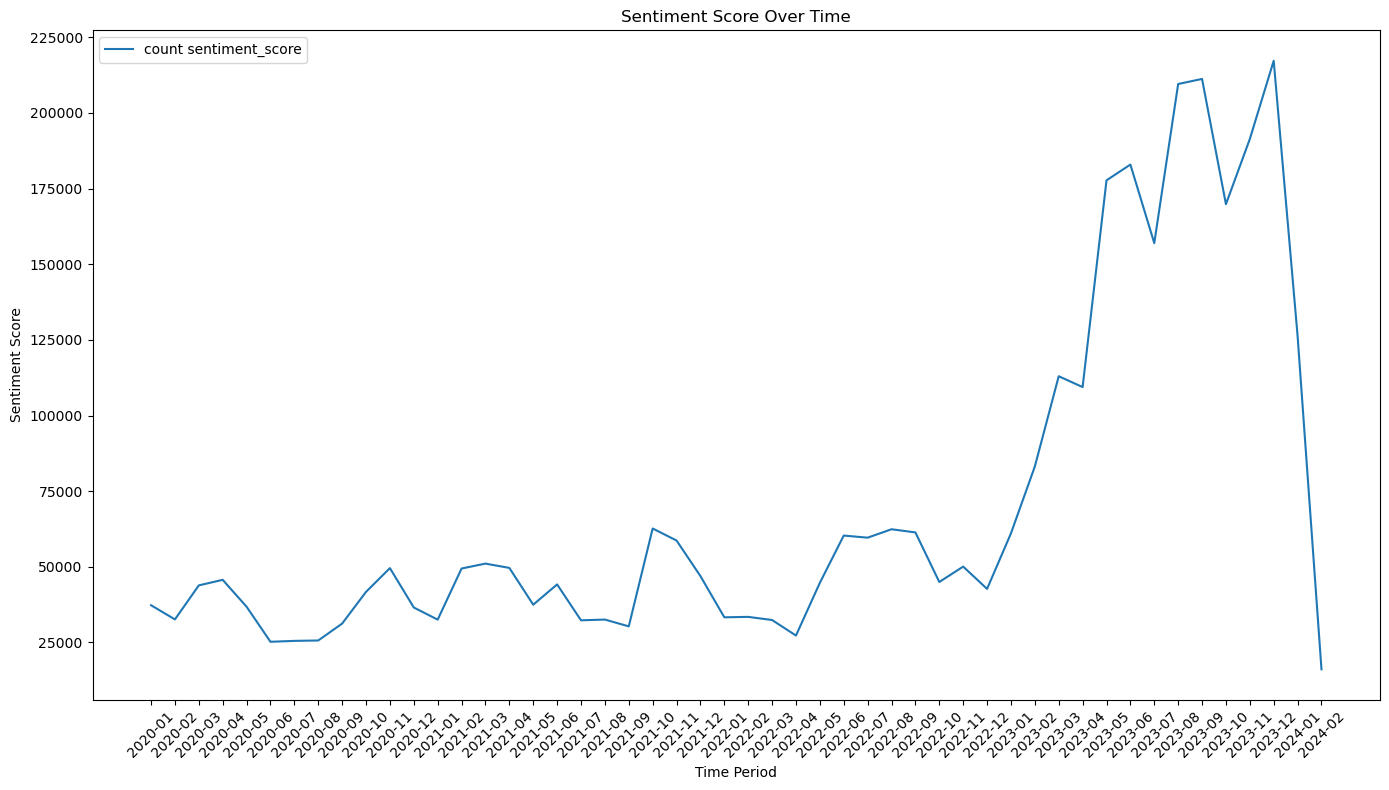

In [32]:
# Count sentiment(= count sentence)
plot_sentiment_over_time(df_merged, 'year_month', 'sentiment_score', ['count'])

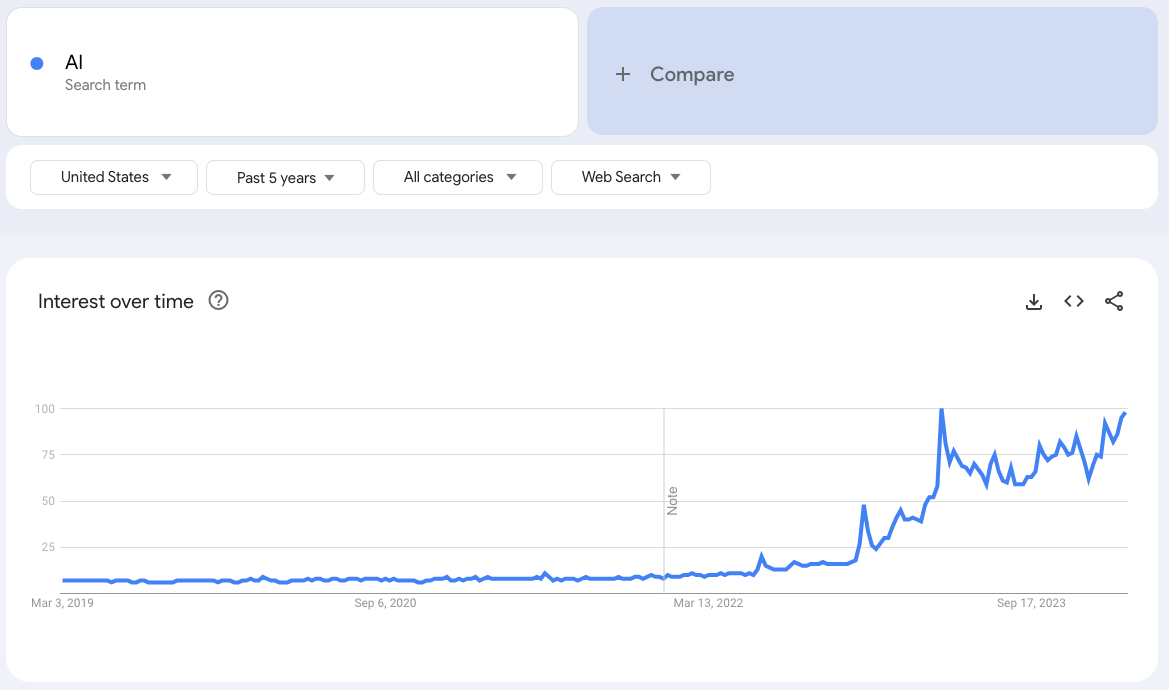

This also aligns generally with the search trends for "AI" on Google Trends, indicating that the news data is consistent　with the search trend.

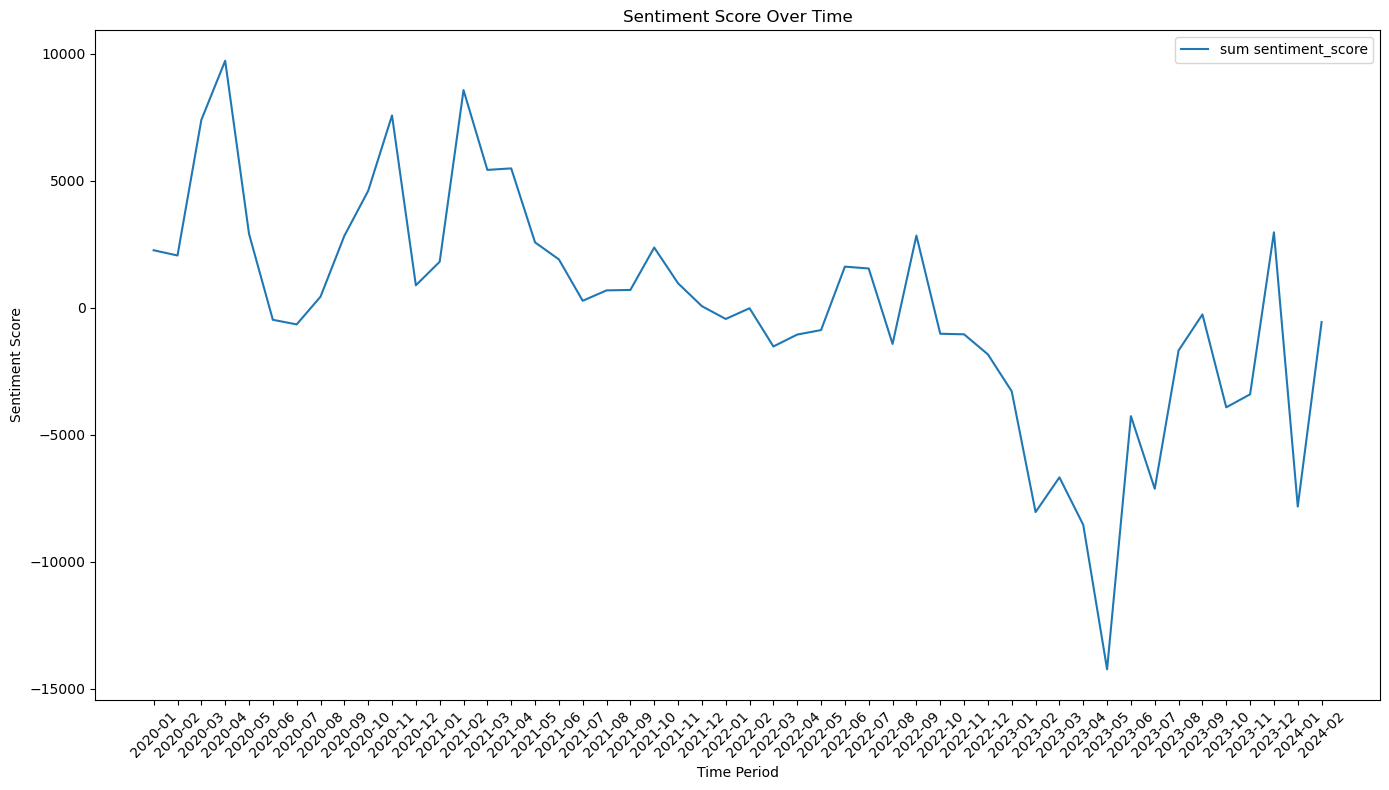

In [33]:
# Sum sentiment
plot_sentiment_over_time(df_merged, 'year_month', 'sentiment_score', ['sum'])

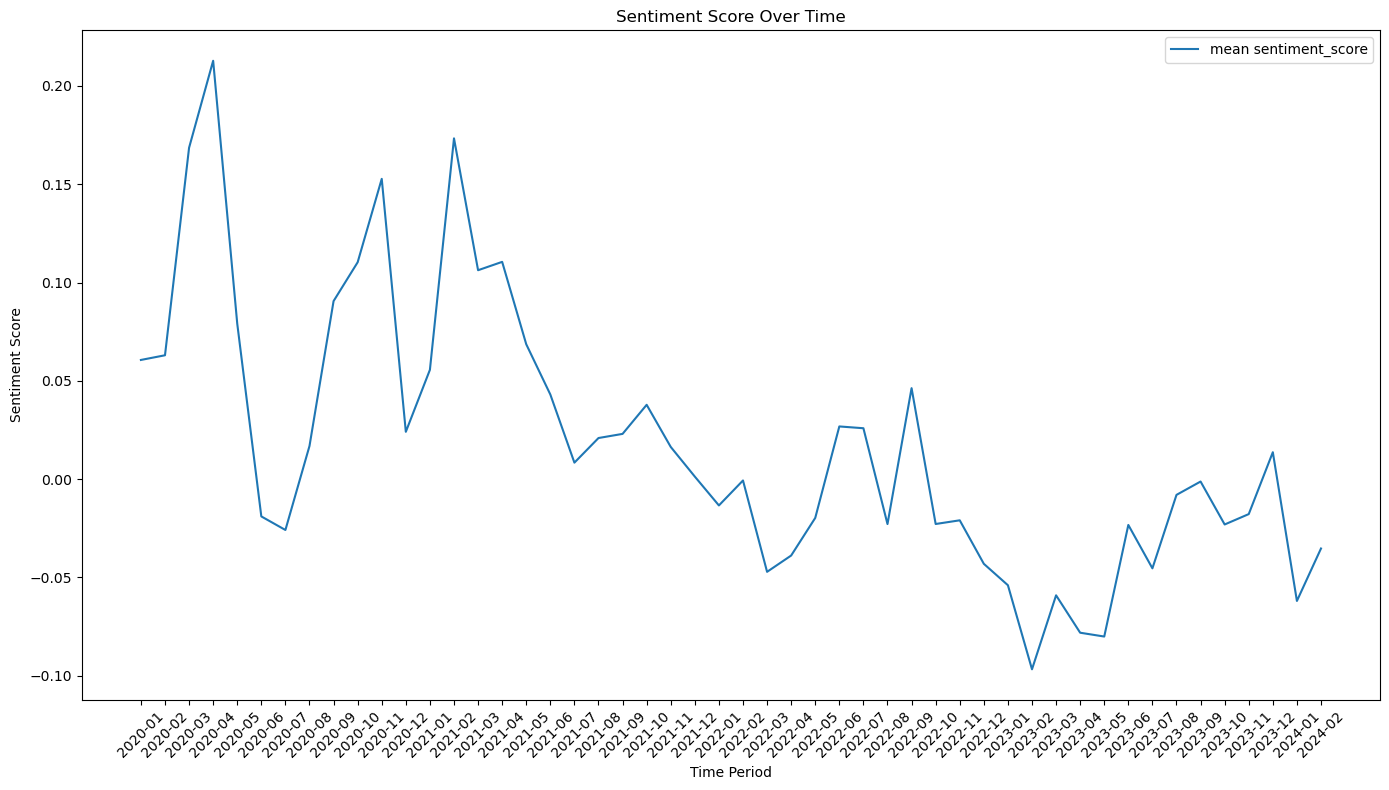

In [34]:
# Average sentiment(sentence)
plot_sentiment_over_time(df_merged, 'year_month', 'sentiment_score', ['mean'])

Comments for Overall Sentiment Trend 
- The news has been on a sharp increase since the end of 2022 (the drop in February 2024 is simply due to fewer data being collected).
- The average sentiment score had been declining, but there was a rebound starting from 2023.
- These trends are expected to be closely related to the release of ChatGPT at the end of November 2022.

## 2. Sentiment by Topic

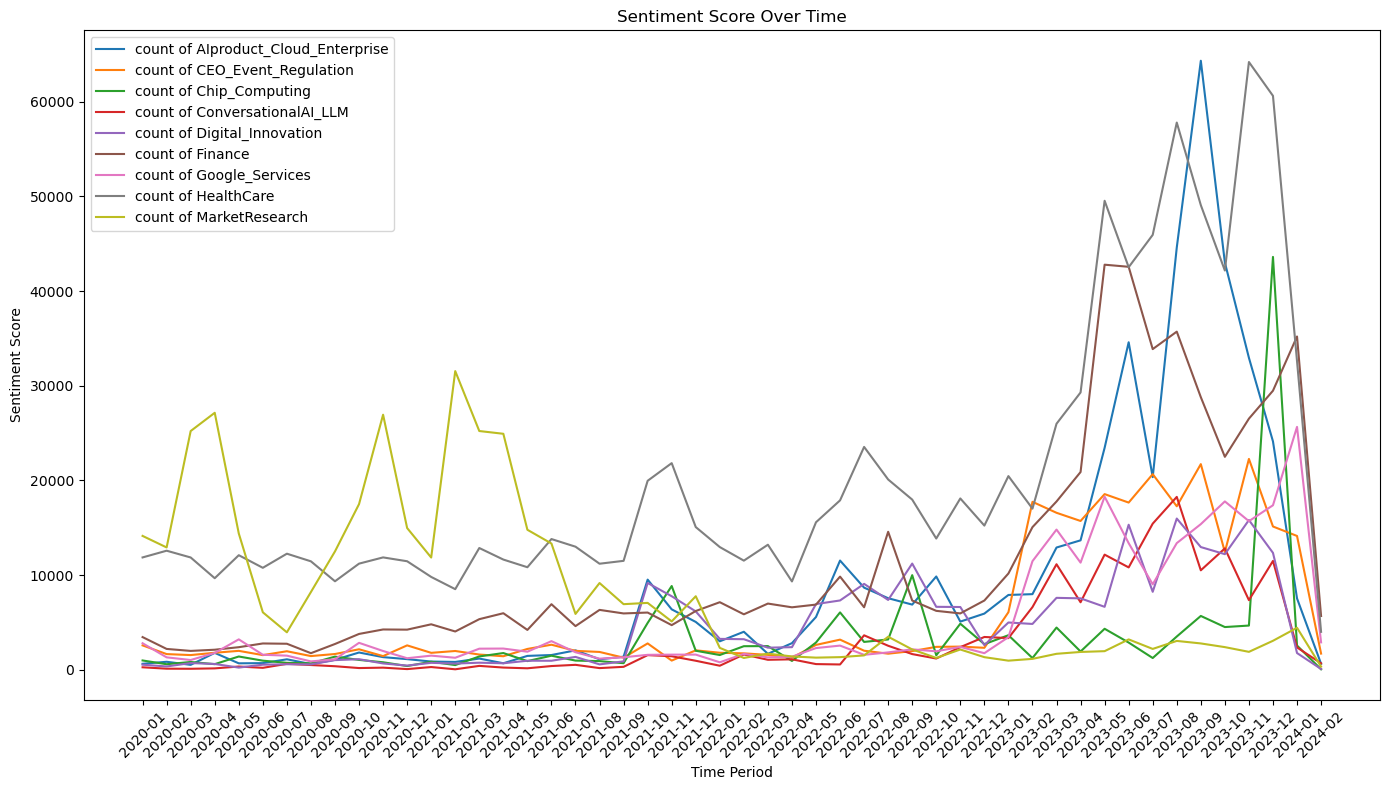

In [35]:
# Topic Count
plot_sentiment_over_time(df_merged, 'year_month', 'sentiment_score', ['count'], 'topic')

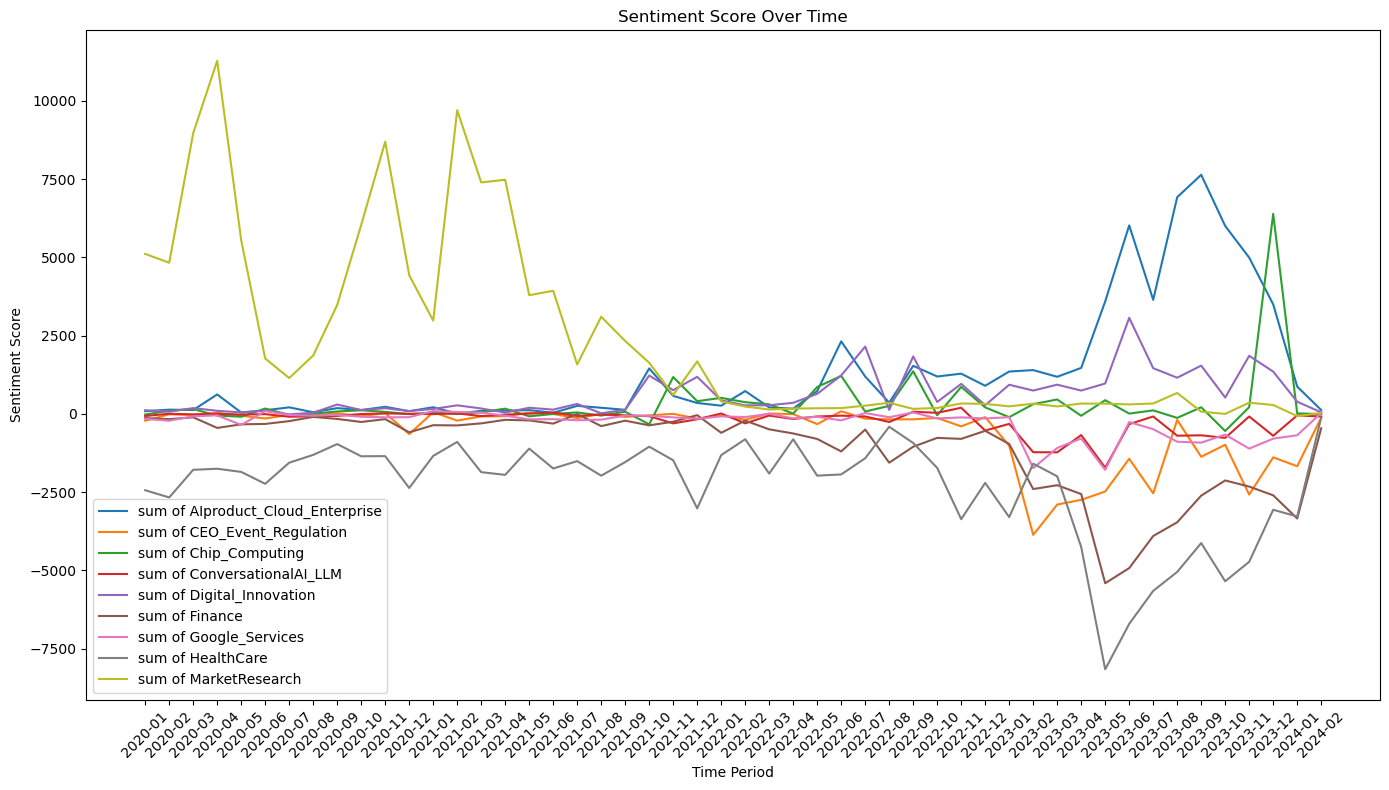

In [36]:
# Topic Sentiment(Sum)
plot_sentiment_over_time(df_merged, 'year_month', 'sentiment_score', ['sum'], 'topic')

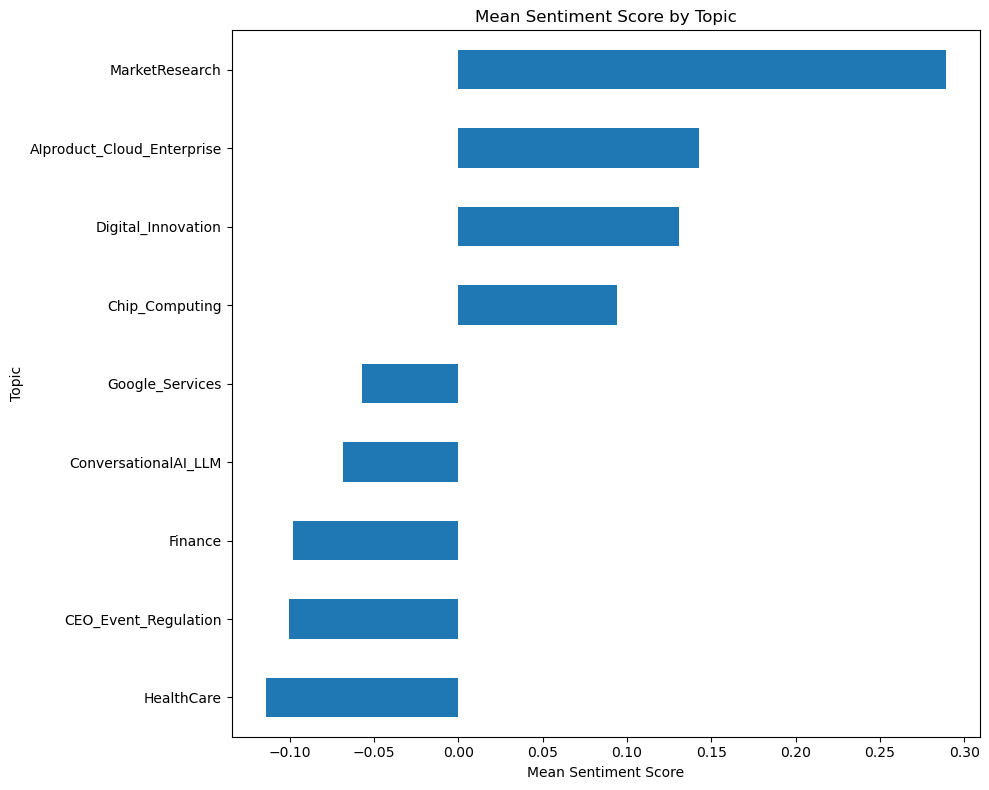

In [37]:
# Topic Sentiment Mean
plot_sentiment_by_category(df_merged, 'topic', 'sentiment_score', 'mean')

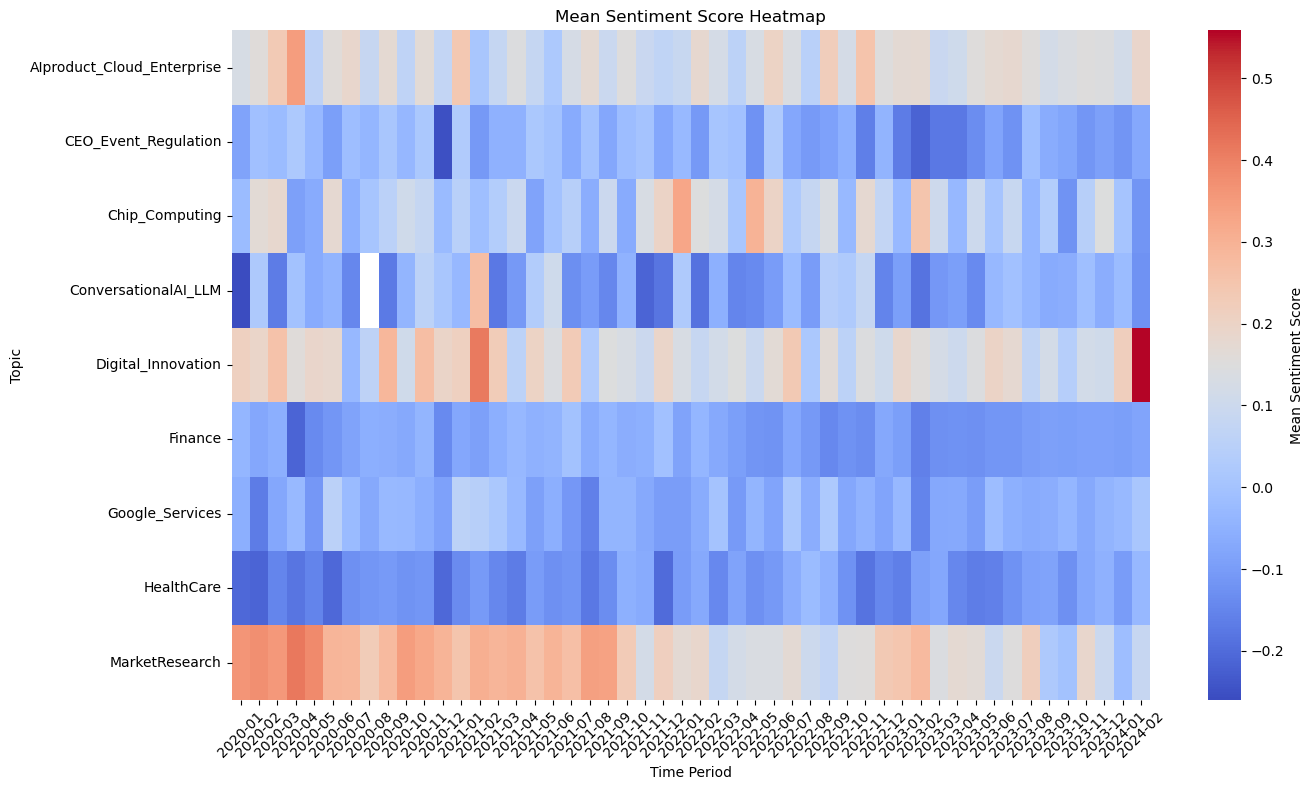

In [38]:
# Topic Sentiment Mean
plot_sentiment_heatmap(df_merged, 'year_month', 'sentiment_score', 'topic', aggregation='mean')

In [39]:
# Healthcare Low Score example
df_healthcare = filter_rows_by_words(df_merged, 'sentence', 'HealthCare')
df_healthcare = filter_rows_by_words(df_healthcare, 'sentence', 'AI')
df_healthcare[df_healthcare['topic'] == 'HealthCare'].sort_values(by='sentiment_score').iloc[[54,57]]

doc_id  sentence_id  \
3250966   72369           45   
4004513   89054            1   

                                                                                                                                                                                                                                                                                                                                                                                                                                           sentence  \
3250966                                                                                                                                                                                                                                                    On the basis of Cancer Type the AI in Cancer Diagnostics Market is divided into Breast Cancer Lung Cancer Prostate Colorectal Cancer Brain Tumor Skin Cancer Cervical Cancer and Others.   
4004513  How AI found the words to kill cancer cells - Impact Lab Skip to content A Laboratory of the Future Human Experience Home Futurati Podcast Futurist Speaker Book Thomas Frey DaVinci Institute About How AI found the words to kill cancer cells Impact Lab Cancer How AI found the words to kill cancer cells Cancer Scanning electron micrograph of a human T lymphocyte also called a T cell from the immune system of a healthy donor.   

                                                                                                            entities  \
3250966                                                                                  [[Breast Cancer Lung, ORG]]   
4004513  [[A Laboratory of the Future Human Experience Home Futurati, ORG], [Thomas Frey DaVinci Institute, PERSON]]   

        entities_manual  sentiment_score sentiment       topic       date  \
3250966              []        -3.258269  negative  HealthCare 2022-12-20   
4004513              []        -3.257745  negative  HealthCare 2022-12-17   

        year_month  
3250966    2022-12  
4004513    2022-12

In healthcare-related contexts, the presence of words such as 'Cancer' or 'Kill' may lead to a tendency for the sentiment to become negative.

Comments for Sentiment Analysis by Topics
- After appearance of ChatGPT, sentiments for topics such as AI Product_Cloud_Enterprise, Digital_Innovation, and Chip_Computing have surged dramatically. 
- On the other hand, the scores for HealthCare and CEO_Event_Regulation have declined. In healthcare-related contexts, the presence of words such as ‘Cancer’ or ‘Kill’ may lead to a tendency for the sentiment to become negative. Therefore, it is necessary to verify whether the sentiment towards healthcare themes themselves is negative.
- It is evident that discussions related to regulation are prevalent in AI after the introduction of ChatGPT.
- Regarding Google_Services, while there is a high regard for the cloud, the low evaluation of Bard could potentially be a headwind for sentiment (details to follow).

## 3. Sentiment by Organization

#### Entities Overview

In [40]:
# Count entities by type
entity_types = ['ORG', 'PRODUCT', 'GPE', 'PERSON']
top_n = 100

top_entities_df = count_top_entities(df_merged['entities'], entity_types, top_n)
top_entities_df

ORG  \
0                                    AI (163769)   
1                                 Google (46702)   
2                              Microsoft (41188)   
3                                ChatGPT (34820)   
4                  Gray Media Group Inc. (32587)   
5                       Gray Media Group (22491)   
6                   Gray Television Inc. (21534)   
7                                    IBM (20299)   
8                                 Nvidia (17196)   
9                Artificial Intelligence (13726)   
10                                NVIDIA (13503)   
11                                 Apple (13424)   
12                                Amazon (13416)   
13                                OpenAI (12583)   
14                              Facebook (10785)   
15                                    ML (10274)   
16                               Samsung (10015)   
17                                  Intel (9801)   
18                                   Meta (8800)   
19                                Company (8778)   
20                                     LG (7548)   
21             Artificial Intelligence AI (6921)   
22                                 Oracle (6467)   
23                                   Bard (6227)   
24                                    AMD (6067)   
25                                     EU (6039)   
26                                  Tesla (5976)   
27                                  Baidu (5072)   
28                              Instagram (4983)   
29                               Deloitte (4599)   
30                                Reuters (4560)   
31                                    SAS (4434)   
32                               Alphabet (4378)   
33                                     RD (4364)   
34                                    GPT (4172)   
35                                Twitter (4066)   
36                                Googles (3831)   
37                                Digital (3777)   
38               ServicePrivacy PolicyEEO (3693)   
39                      BureauInvestigate (3669)   
40                                    SEC (3579)   
41                                 Forbes (3497)   
42                             Healthcare (3482)   
43                                    FDA (3355)   
44                        CaptioningAudio (3266)   
45                             Microsofts (3256)   
46                                Gartner (3125)   
47                                    DDN (3106)   
48                          Generative AI (2985)   
49                               LinkedIn (2970)   
50                                  Pixel (2944)   
51                           Google Cloud (2922)   
52                             Supermicro (2901)   
53                         Facebook Share (2864)   
54                                   AIML (2824)   
55                             Salesforce (2667)   
56                       Machine Learning (2646)   
57                                   NASA (2505)   
58                             Nasdaq.com (2491)   
59                            Nasdaq Inc. (2482)   
60                                  Adobe (2470)   
61                      Matrix AI Network (2464)   
62                            EnterReturn (2463)   
63                                 Gemini (2404)   
64  ServicePrivacy PolicyEEO StatementFCC (2388)   
65                         NewscastsPress (2353)   
66                                   Sony (2327)   
67                             healthcare (2323)   
68                      Conversational AI (2261)   
69                        The Motley Fool (2227)   
70                         Google Cloud's (2131)   
71                               Qualcomm (2121)   
72                                    NLP (2063)   
73                                    FCC (2026)   
74                                Android (2023)   
75                                    GPU (2019)   
76                                 Huawei

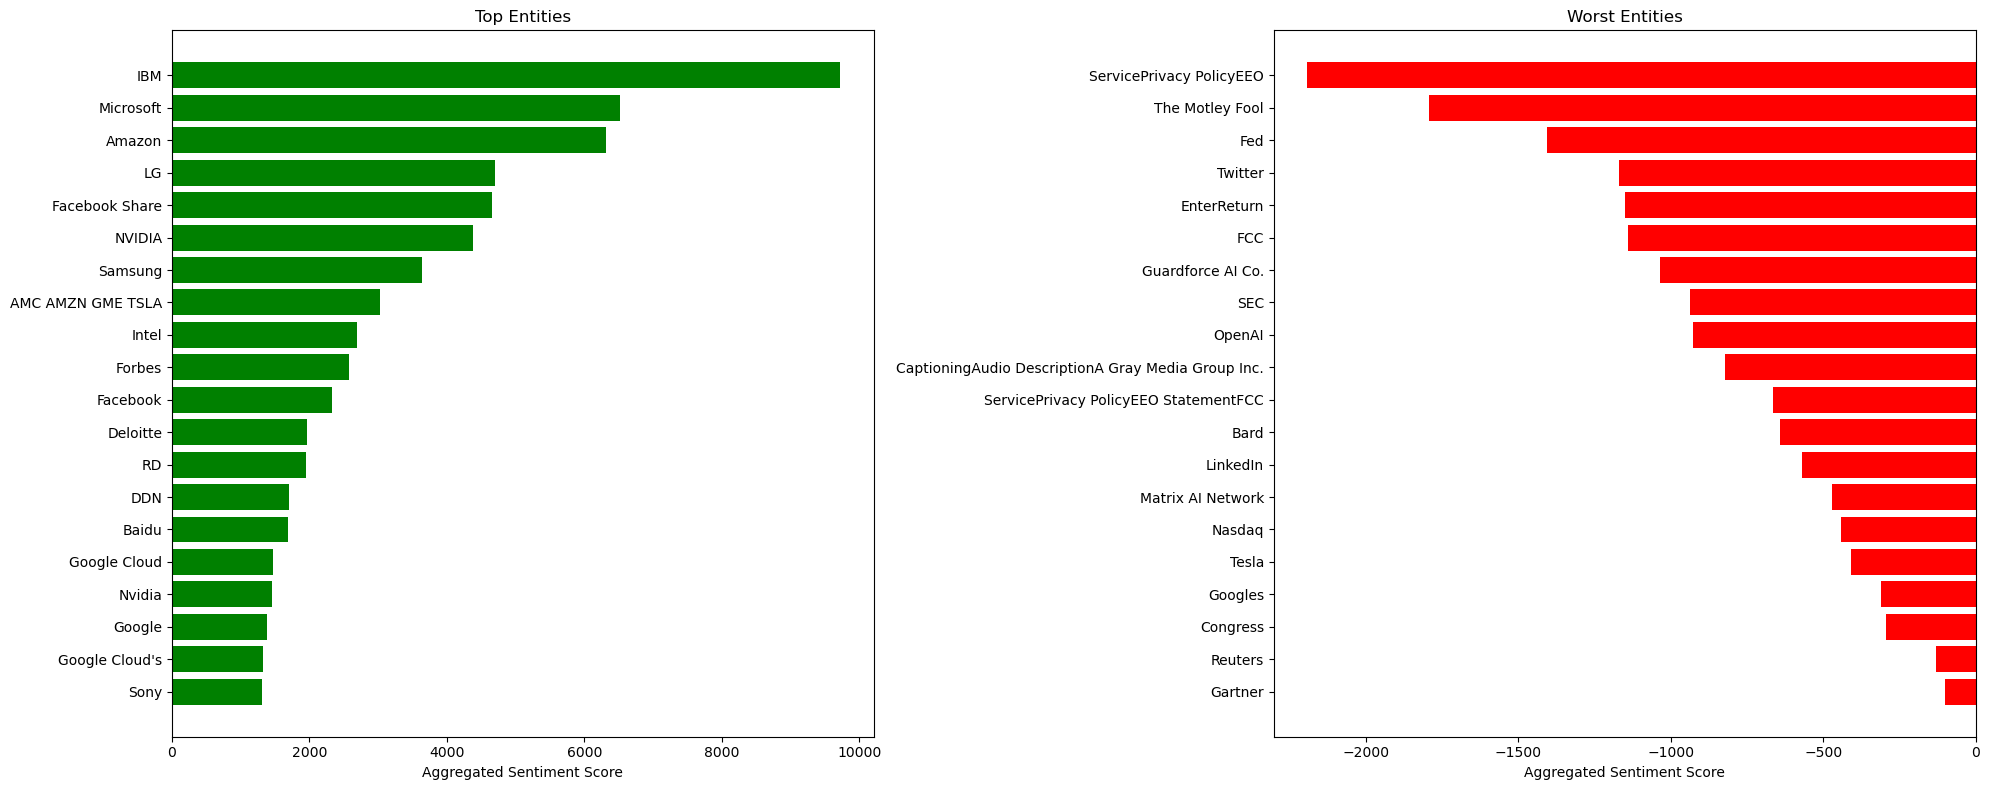

In [41]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities' 
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['ORG']
exclude_entities = ['AI', 'Artificial Intelligence', 'Artificial Intelligence AI', 'the Artificial Intelligence', 'BureauInvestigate',
                    'Healthcare', 'Company', 'ML', 'Gray Media Group', 'Gray Media Group Inc.', 'Gray Television Inc.', 'CaptioningAudio']

top_n = 20
min_count = 1500


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

- OpenAI is experiencing negative sentiment, presumably influenced by news related to regulations. 
- It is assumed that the Federal Reserve (Fed) and the Securities and Exchange Commission (SEC) are having a negative impact on market sentiment.

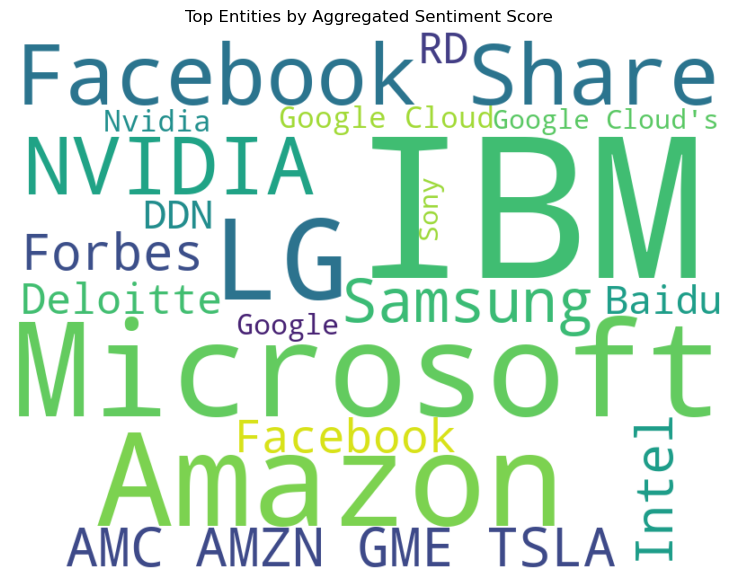

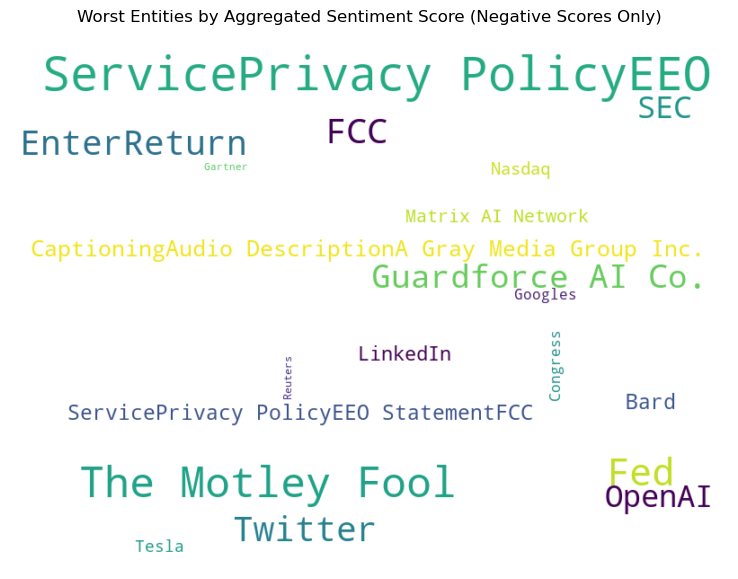

In [42]:
plot_top_worst_entities_wordcloud(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

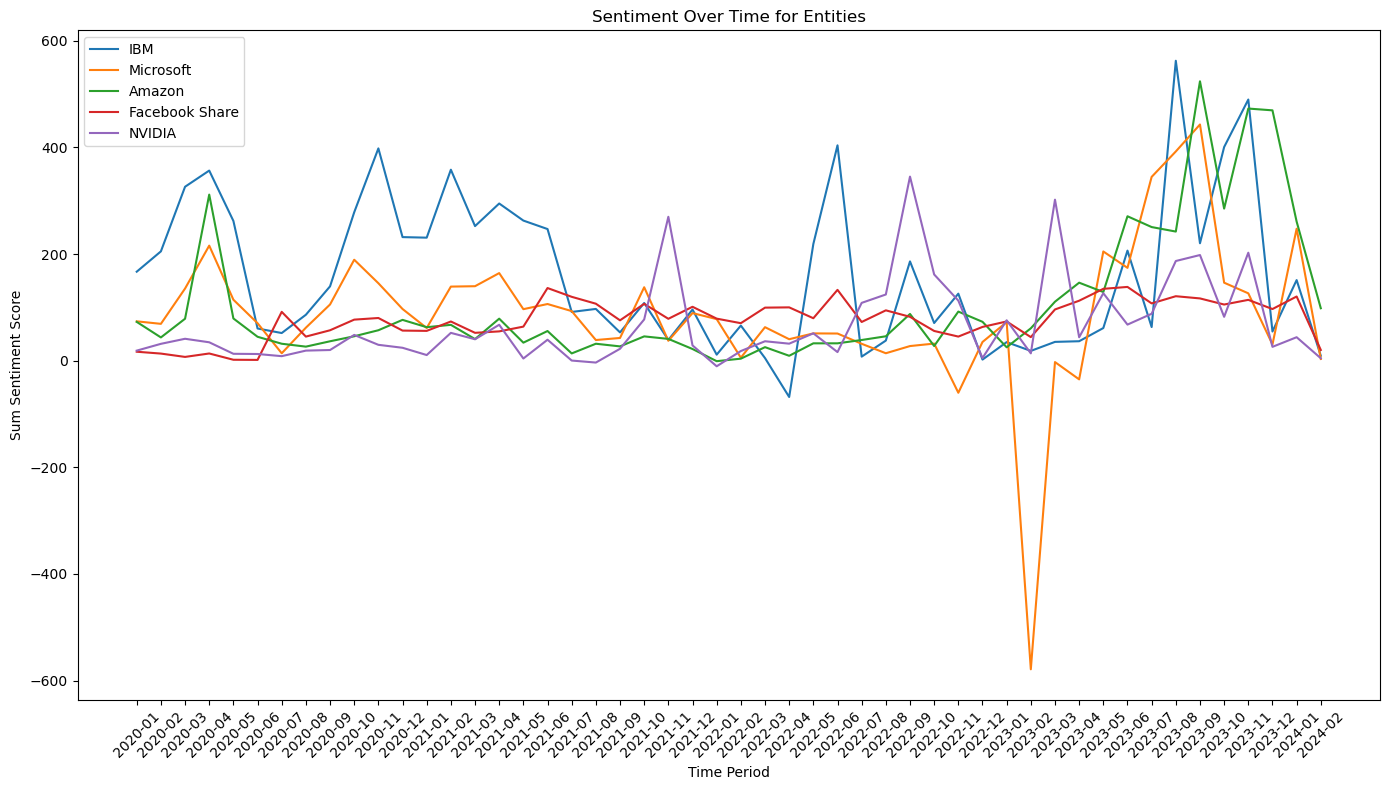

In [43]:
# Sentiment Score over time for top entities

top_names = ['IBM', 'Microsoft', 'Amazon', 'Facebook Share', 'NVIDIA']

plot_individual_entity_sentiment_over_time(
    df=df_merged, 
    period_col='year_month', 
    sentiment_col='sentiment_score', 
    entities=top_names, 
    entity_types = entity_types,
    aggregation=aggregation_method
)

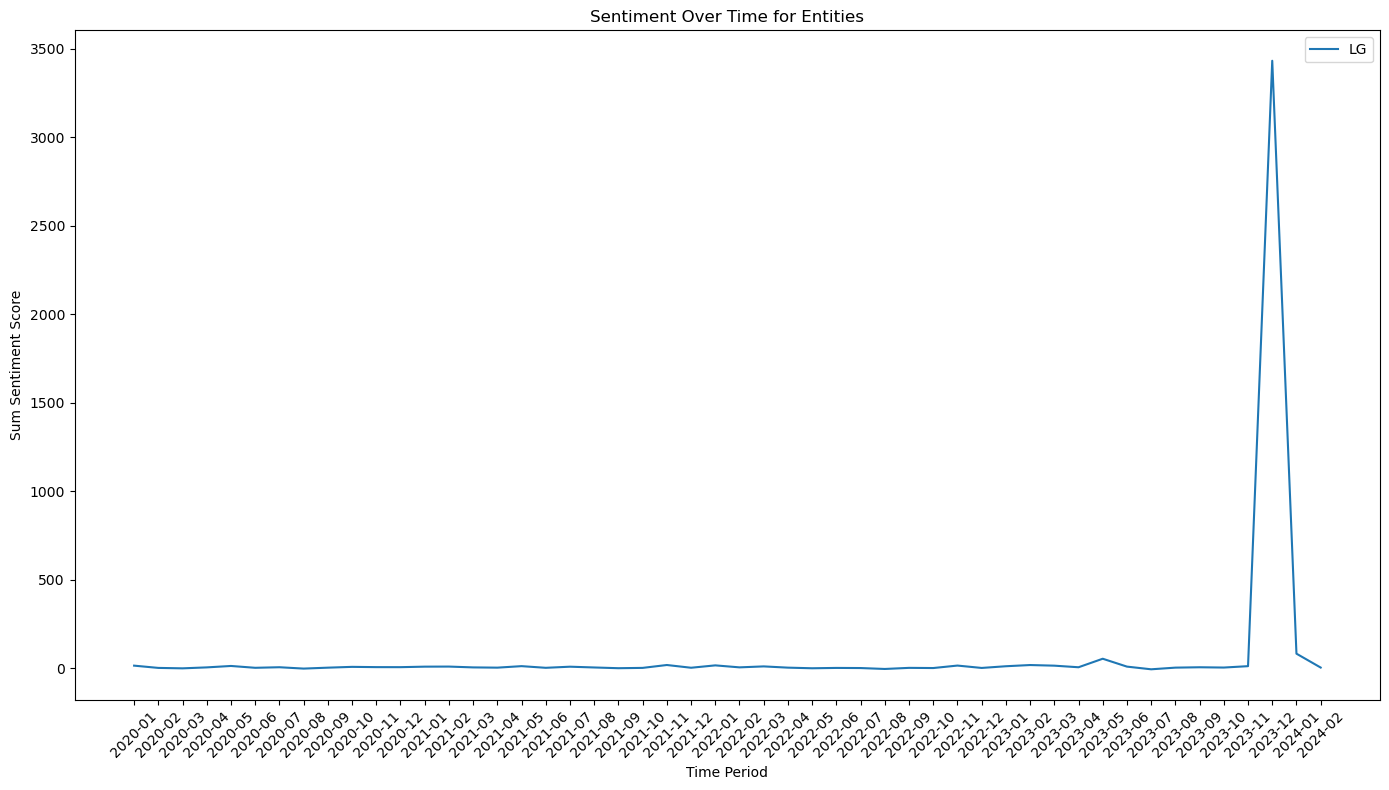

In [44]:
# Sentiment Score over time for top entities

top_names = ['LG']

plot_individual_entity_sentiment_over_time(
    df=df_merged, 
    period_col='year_month', 
    sentiment_col='sentiment_score', 
    entities=top_names, 
    entity_types = entity_types,
    aggregation=aggregation_method
)

In [45]:
# What happend to LG in 2023-12?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'LG', 'ORG')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-12'][['year_month','sentence','sentiment_score']].head()

year_month  \
18845    2023-12   
18849    2023-12   
18850    2023-12   
18852    2023-12   
18856    2023-12   

                                                                                                                                                                                                                                                                                                                                                                                                                                   sentence  \
18845  LG USHERS IN 'ZERO LABOR HOME' WITH ITS SMART HOME AI AGENT AT CES 2024 Skip to contentNewsWeatherSportsThe ThreeAdvertiseWatch LiveHomeNewsLocalStateNationalPoliticsTDCJ InvestigationWatch LiveWeatherInteractive RadarMap RoomPinPoint PodcastSevere WeatherHurricaneLive EyeDog Walking ForecastAllergy ReportClosingsSportsHigh SchoolTexas AMSam HoustonStats PredictionsHow to WatchThe ThreeContestsApplauseTriviaCommunity   
18849                                                                                                                                                                                                                                                                                  LG's smart home AI agent boasts robotic AI and multi-modal technologies that enable it to move learn comprehend and engage in complex conversations.   
18850                                                                                                                                                                                                                                         An all-around home manager and companion rolled into one LG's smart life solution enhances users' daily lives and showcases the company's commitment to realizing its Zero Labor Home vision.   
18852                                                                                                                                                                                                                                                                                                            PRNewswireWith its advanced 'two-legged' wheel design LG's smart home AI agent is able to navigate the home independently.   
18856                                                                                                                                                                                                                         Through LG's latest collaboration with Qualcomm Technologies Inc. the AI agent is equipped with the Qualcomm Robotics RB5 Platform enabling powerful on-device AI features such as face and user recognition.   

       sentiment_score  
18845         0.724181  
18849         0.967764  
18850         1.485312  
18852         0.828948  
18856         0.435025

LG is indeed related to AI (LG's smart home AI agent), but subsequent analysis revealed that multiple noise sentences like 'Please enable JavaScript to ensure you get the most out of the LG site products and services' are inflating the score. Therefore, they will be excluded from the time-series graph.

In [46]:
# What happend to Microsoft in 2023-02?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Microsoft', 'ORG')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-02'][['year_month','sentence','sentiment_score']].sort_values(by='sentiment_score').head(2)

year_month  \
2448841    2023-02   
3746773    2023-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
2448841  Microsoft unveils Bing search engine that uses OpenAI's ChatGPT AI tech - CBS News State of the Union CBS News App Ukraine Crisis COVID Pandemic CBS News Live Managing Your Money Essentials Shopping Newsletters News US World Politics Entertainment Health MoneyWatch CBS Village Technology Science Crime Sports Essentials Turkey-Syria earthquakes death toll soars over 7000 Some of the notable guests coming to Biden's State of the Union address 4 people taken to hospital after fire forces United...   
3746773  After Google's Bard AI Microsoft's AI-Powered Bing Also Making Factual Errors Report OPEN IN APPJagran LogoShare MarketTop DealsWeb StoriesAndroidSearchMenuNewsTechnologyMore In NewsPolitical Storm In Maha Over Assam Govt's Claims On Jyotirlinga Oppn Attacks BJP Says 'Gods Taken Away' India'Akin To Suppressing Public Voice' Arvind Kejriwal On Income Tax Survey At BBCIndiaDelhi Road Rage Man Stabbed To Death In Nangloi Family Blames Cops 3 DetainedIndiaTax Survey At BBC Continues For Second D...   

         sentiment_score  
2448841        -3.245173  
3746773        -3.206933

In [47]:
# What happend to Microsoft in 2023-09?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Microsoft', 'ORG')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-09'][['year_month','sentence','sentiment_score']].iloc[16:20]

year_month  \
76653    2023-09   
76665    2023-09   
79175    2023-09   
79176    2023-09   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  sentence  \
76653  The new AI camera lenses will let users create photos videos and GIFs with different effects including lenses that are powered by Microsoft's collaboration with Snapchat maker Snap.2d agoTechCrunchMicrosoft Bing to gain more personalized answers support for DALLE-E 3 and watermarked AI imagesMicrosoft's Bing is gaining a number of AI improvements including support for OpenAI's new DALLE-E 3 model more personalized answers in search and chat and tools that will watermark images as being AI-ge...   
76665                                                                                                                                    Users can share a private link to their decks which could be useful for classmates looking to study the same information together or teachers who want to create decks for their students.3d agoEngadgetEngadget Podcast iPhone 15 Pro reviews Microsoft picks AI over SurfaceThis week Cherlynn chats about her experience reviewing the iPhone 15 Pro and Apple Watch Series 9.   
79175  Idomoo Announces Commercial Launch of Lucas AI Video Creator Apple Cloud IoT Intelligenza artificiale Le Voci dellAI Prodotti Hardware Mobile Networking e TLC 5G Sicurezza Software Storage Soluzioni Agricoltura Architettura Design Automotive Manufacturing Retail e-Health Smart Home Utilities Webinar Aziende Aws Cisco Dell Hpe Google Ibm Meta Microsoft Oracle Salesforce Sap Vmware Contatti Iscriviti alla newsletter White paper Mappa dei system integrator Cerca Contatti Iscriviti alla newslett...   
79176                                              Prodotti Hardware Mobile Networking e TLC 5G Sicurezza Software Storage Soluzioni Agricoltura Architettura Design Automotive Manufacturing Retail e-Health Smart Home Utilities Webinar Aziende Aws Cisco Dell Hpe Google Ibm Meta Microsoft Oracle Salesforce Sap Vmware Home Business Wire Idomoo Announces Commercial Launch of Lucas AI Video Creator Business Wire Idomoo Announces Commercial Launch of Lucas AI Video Creator di Business Wire 22 Settembre 2023   

       sentiment_score  
76653         1.790184  
76665         1.316114  
79175         0.383689  
79176         0.383689

In [88]:
# What happend to Amazon in 2023-09?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Amazon', 'ORG')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-09'][['year_month','sentence','sentiment_score']].head(3)

year_month  \
3869    2023-09   
3873    2023-09   
3874    2023-09   

                                                                                                                                                                                                                     sentence  \
3869                                                               Amazon creates AI tool for sellers to generate product listings automatically - Good e-Reader Good e-Reader Search for App StoreContactAdvertisingCustomer   
3873                                         While Amazon doesnt explicitly detail its training data sources its likely that the retail giant utilized its own extensive listing data to train these machine learning models.   
3874  Previously Amazon had employed machine learning and deep learning techniques to extract and enrich product information but these new-generation AI capabilities represent a significant advancement in this technology.   

      sentiment_score  
3869         1.485312  
3873        -0.203005  
3874         0.304328

Comments for Sentiment Analysis by Organizations
- The top positive sentiment organizations include IBM, Microsoft, Amazon, Facebook, and NVIDIA. 
- Looking at the scores of the top 5 over time, it is evident that concerns about Microsoft's Bing increased after the introduction of ChatGPT. However, the sentiment improved following news about Bing's enhancements. 
- mazon saw a rise in sentiment due to the utilization of AI tools in its e-commerce services.
- Regarding Facebook, there has been no significant change in sentiment, suggesting the possibility that it has not been able to ride the wave of GenAI.

## 4. Sentiment by Product

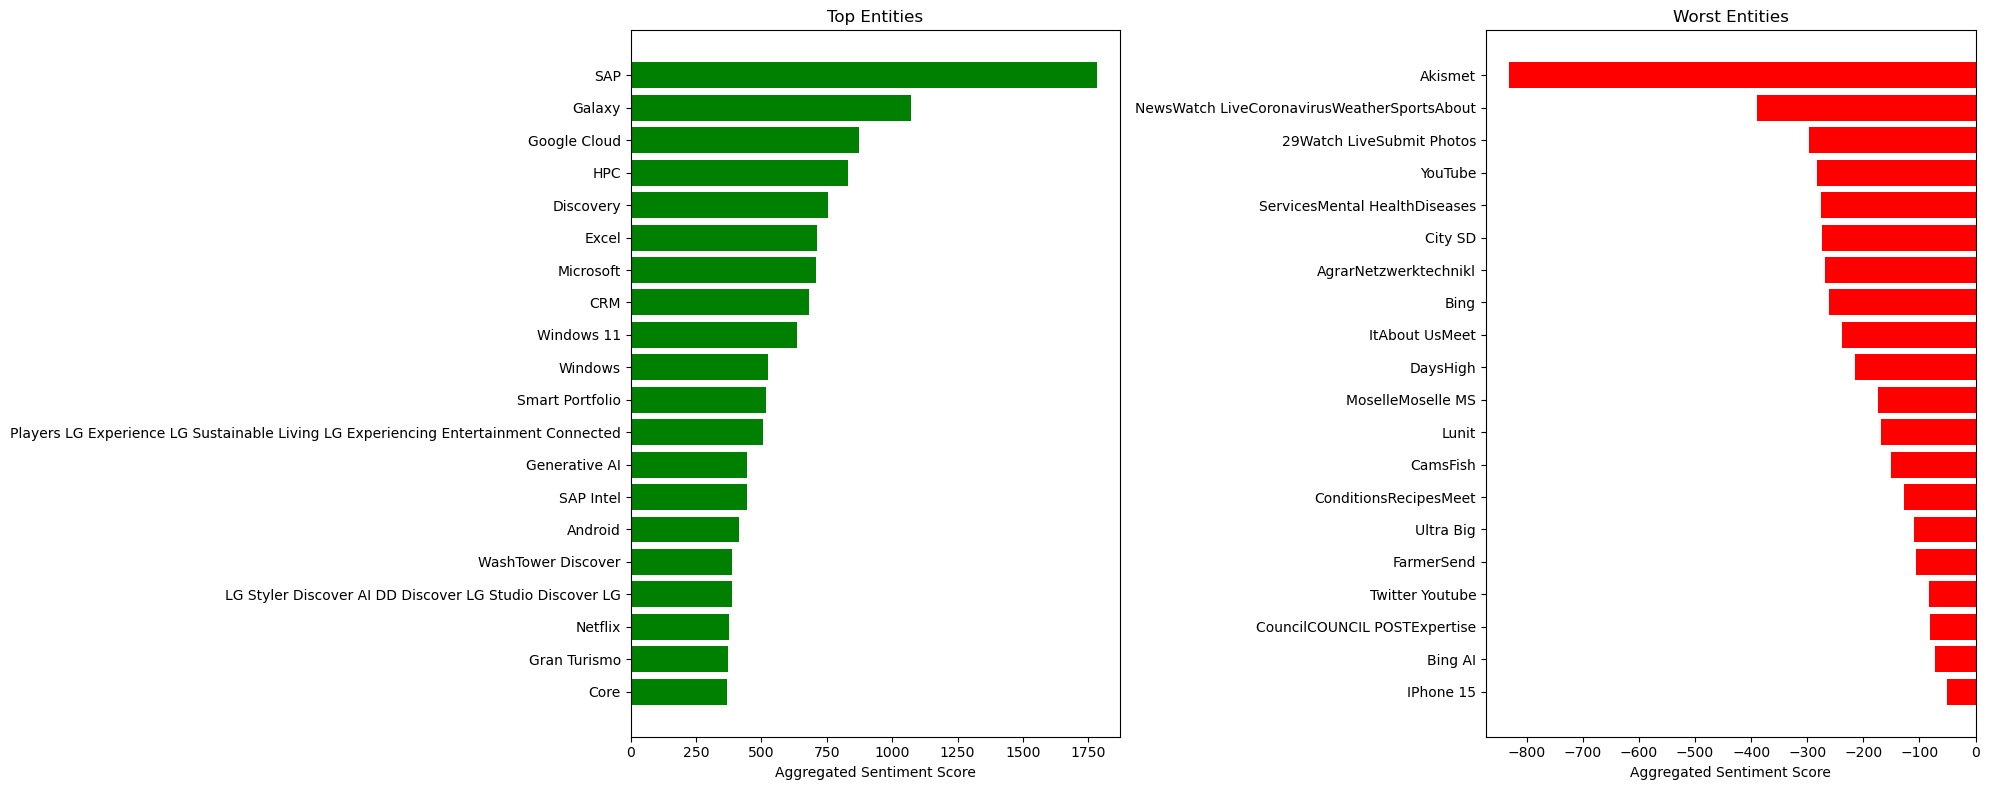

In [48]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities' 
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['PRODUCT']
# The high scores for JavaScript are mostly due to sentences such as 'Please enable JavaScript to ensure you get the most out of the LG site products and services,' so I will exclude it
exclude_entities = ['AI', 'Best', 'Buy More SaveMore', 'Share', 'Reddit VKontakte Share', 'Water Air', 'CouponsPurple Squarespace','GT', 'JavaScript']
top_n = 20
min_count = 250


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

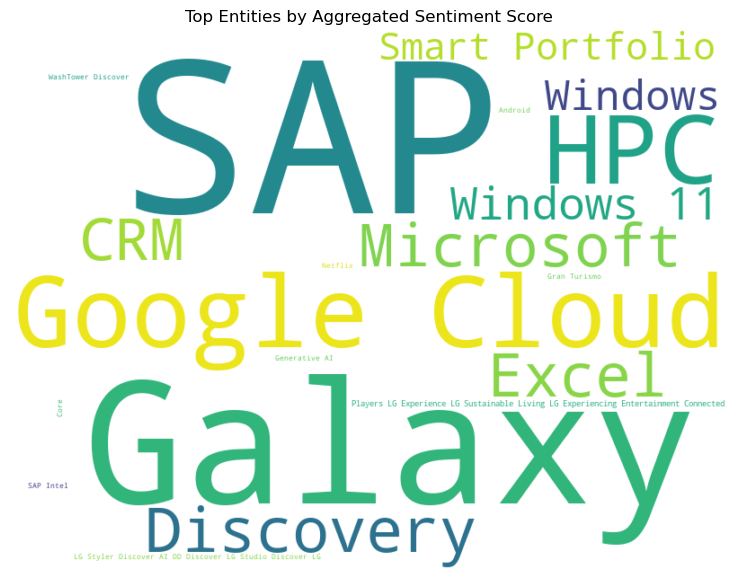

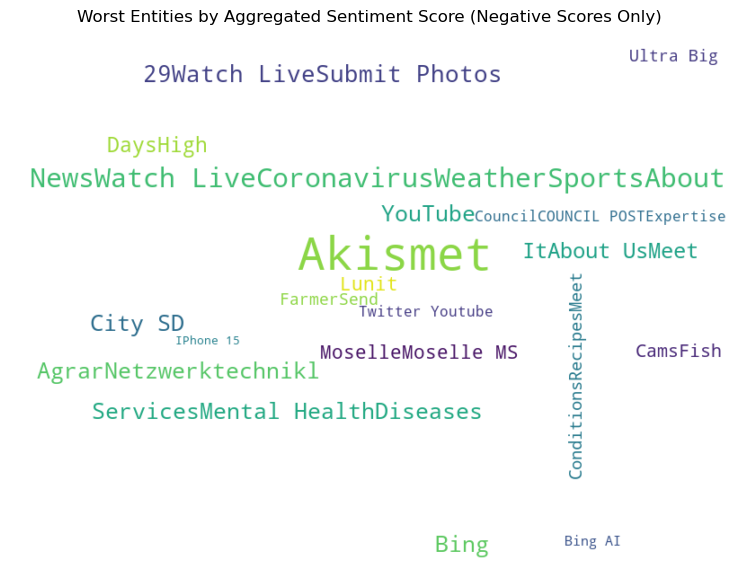

In [49]:
plot_top_worst_entities_wordcloud(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

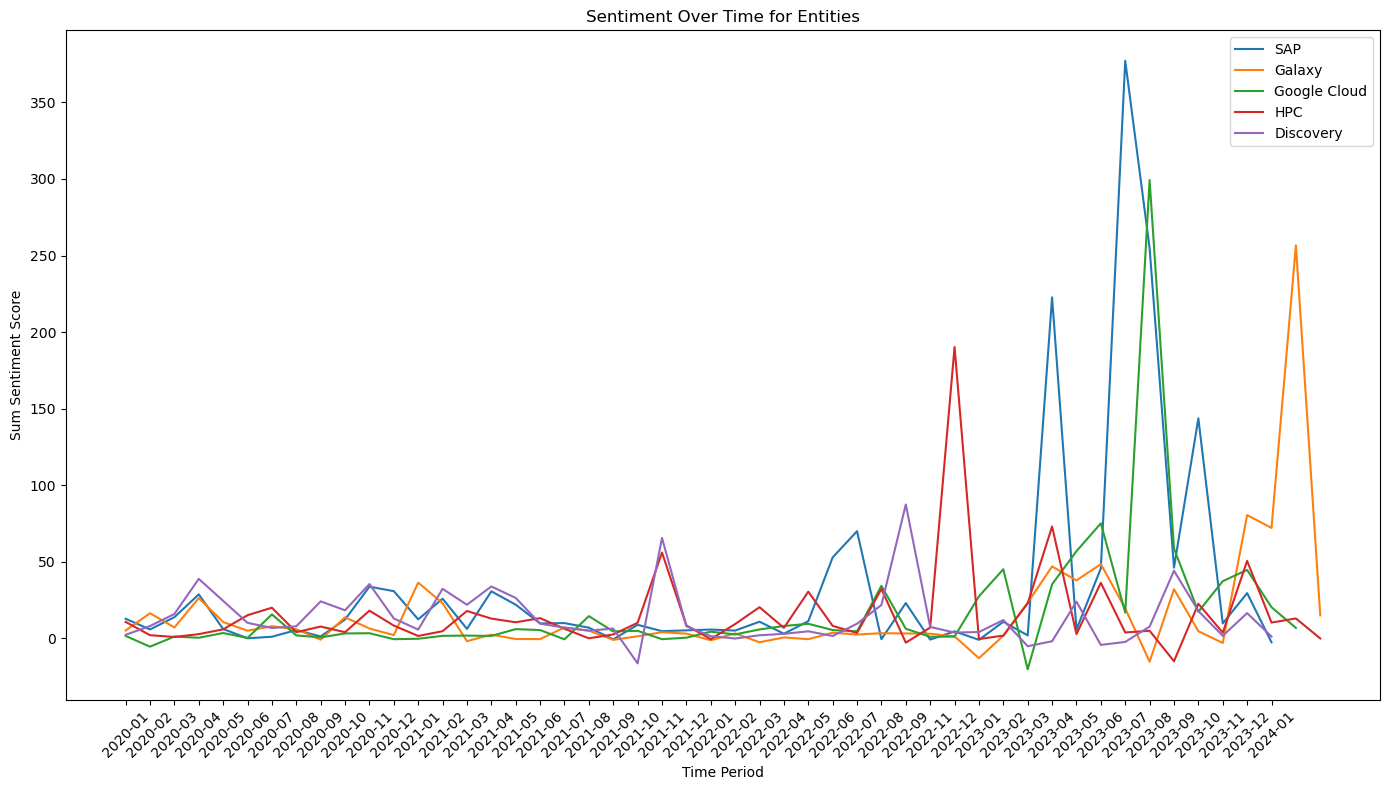

In [50]:
# Sentiment Score over time for top entities

top_names = ['SAP','Galaxy', 'Google Cloud', 'HPC', 'Discovery']

plot_individual_entity_sentiment_over_time(
    df=df_merged, 
    period_col='year_month', 
    sentiment_col='sentiment_score', 
    entities=top_names, 
    entity_types = entity_types,
    aggregation=aggregation_method
)

In [51]:
# What happend to SAP in 2023-06?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'SAP', 'PRODUCT')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-06'][['year_month','sentence','entities','sentiment_score']].head()

year_month  \
1180535    2023-06   
1268081    2023-06   
1268087    2023-06   
1268088    2023-06   
1268099    2023-06   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
1180535                                                                                                                                                                                                                                                                                                                                                                                                                                                       The disk contained personal records of over 100 SAP employees.   
1268081  TECHNOLOGYSAP to embed IBM Watson Artificial Intelligence into SAP SolutionsThe two companies held an event in Riyadh on Wednsday that highlighted how to accelerate digital transformation in the Kingdom in line Vision 2030 Press ReleaseJune 15 2023TECHNOLOGYPHOTORiyadh KSA - SAP and IBM announced that IBM Watson technology will be embedded into SAP solutions to provide new AI-driven insights and automation to help accelerate innovation and create more efficient and effective user experiences...   
1268087                                                                                                                                                                                                                                                            This milestone collaboration with IBM aims to provide SAP customers a better user experience faster decision-making and greater insights to help transform their business processes said Christian Klein CEO and Member of the Executive Board of SAP SE.   
1268088                                                                                                                                                                                                                                                                                                                                   Working together to incorporate additional AI machine learning and other intelligent technologies into SAP solutions can lead to better business outcomes for our joint customers.   
1268099                                                                                                                                                                                                                                     In addition to natively embedding IBM Watson AI capabilities into SAP solutions SAP and IBM are collaborating on generative AI and large language models aimed to deliver consistent continuous learning and automation based on SAPs mission-critical application suite. -Ends-   

                                                                                                                                                                                                                                                                                               entities  \
1180535                                                                                                                                                                                                                                                               [[100, CARDINAL], [SAP, PRODUCT]]   
1268081  [[IBM, ORG], [two, CARDINAL], [Riyadh, GPE], [Wednsday, DATE], [Kingdom, GPE], [Vision 2030 Press, ORG], [ReleaseJune, ORG], [15, CARDINAL], [2023TECHNOLOGYPHOTORiyadh, CARDINAL], [KSA - SAP, ORG

In [52]:
# # What happend to JavaScript in 2023-12?
# df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'JavaScript', 'PRODUCT')
# df_filtered_entity[df_filtered_entity['year_month'] == '2023-12'][['year_month','sentence','entities','sentiment_score']].head(50)

In [91]:
# What happend to Google Cloud in 2023-08?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Google Cloud', 'PRODUCT')
df_filtered_entity[df_filtered_entity['year_month'] == '2023-08'][['year_month','sentence','entities','sentiment_score']].sort_values(by='sentiment_score', ascending=False).head(1)

year_month  \
1419400    2023-08   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
1419400  Read more Google Cloud brings generative AI to Singapores MAS MCI Deploying Generative AI in an Enterprise Setting Opportunities and Challenges More from IBM Tags Google Cloudgenerative AI Read next AZ Asia-Pacific adds watchTowr to cyber security portfolio Hybrid work is entering the 'trough of disillusionment' NEXTGEN celebrates Summer Party 2023 in Singapore Follow us Twitter Facebook LinkedIn RSS Events Channel Asia WIICTA 2023 Channel Asia Innovation Awards 2023 Innovation Awards 2023 i...   

                                                                                                                                                                                                                                                         entities  \
1419400  [(Google Cloud, PRODUCT), (AI, PRODUCT), (IBM, ORG), (Google, ORG), (Cloudgenerative, PRODUCT), (NEXTGEN, PERSON), (Summer Party, EVENT), (2023, DATE), (Singapore, GPE), (Twitter Facebook LinkedIn RSS Events Channel Asia WIICTA, ORG), (ASEAN, ORG)]   

         sentiment_score  
1419400         1.912499

In [54]:
# What happend to HPC in 2022-11?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'HPC', 'PRODUCT')
df_filtered_entity[df_filtered_entity['year_month'] == '2022-11'][['year_month','sentence','entities','sentiment_score']].head()

year_month  \
126840    2022-11   
126849    2022-11   
126859    2022-11   
126863    2022-11   
277349    2022-11   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   sentence  \
126840                                                                                                                                                                                                                                                                                                                             DDN also introduced enhancements to its scalable and flexible monitoring interface DDN Insight to streamline and simplify management and support of HPC and AI infrastructures at-scale.   
126849                                                                                                                                                           Combining cutting-edge GPU processing proven HPC software suites Atos next-generation DLC Direct Liquid Cooling technology and an architecture that is flexible dense and secured by design BullSequana XH3000 delivers both unprecedented performance and unrivaled efficiency which is complemented by DDN's small footprint and economical performance.   
126859                                                                                                                                                                                                                                                                                                          Visit booth 2828 to learn more about the new Reference Architecture in collaboration with Atos DDN Insight enhancements and the rest of DDN's portfolio of products designed for AI and HPC transformation.   
126863                                                                                                                                                             Supporting ResourcesAtos BullSequana XH3000 and DDN A3I Reference ArchitectureDDN A3IDDN EXAScalerDDN InsightDDN at SC22About DDNDDN is the world's largest private data storage company and the leading provider of intelligent technology and infrastructure solutions for enterprise at scale AI and analytics HPC government and academia customers.   
277349  APEX High Performance Computing helps organizations run resource-intensive HPC workloads through an as-a-Service experienceDell Quantum Computing Solution integrates hybrid quantum computing into existing classical computational ecosystemsDell Validated Design for HPC Risk Assessment analyzes large datasets helping financial institutions speed matching of credit offers to risk levelsFull storyDell Technologies NYSEDELL expands its high performance computing HPC portfolio offering powerful so...   

                                                                                                                                                                   entities  \
126840                                                                                                          [[DDN, ORG], [DDN Insight, ORG], [HPC, PRODUCT], [AI, FAC]]   
126849                                                                                     [[HPC, PRODUCT], [Atos, ORG], [BullSequana, ORG], [XH3000, PRODUCT], [DDN, ORG]]   
126859                                                [[2828, CARDINAL], [Reference Architecture, ORG], [Atos DDN Insight, ORG], [DDN, ORG], [AI, PRODUCT], [HPC, PRODUCT]]   
126863  [[ResourcesAtos BullSequana, PERSON], [DDN, ORG], [A3I, PRODUCT], [ArchitectureDDN A3IDDN, ORG], [EXAScal

In [55]:
# What happend to Galaxy in 2024-01?
df_filtered_entity = filter_df_by_entity_and_type(df_merged, 'Galaxy', 'PRODUCT')
df_filtered_entity[df_filtered_entity['year_month'] == '2024-01'][['year_month','sentence','entities','sentiment_score']].head()

year_month  \
5750    2024-01   
5751    2024-01   
5756    2024-01   
5759    2024-01   
5773    2024-01   

                                                                                                                                                                                                                                                                       sentence  \
5750                                                                                                                        In BriefSamsung Electronics launched Galaxy S24 its first generative AI-powered lineup of Galaxy smartphones set to enhance user phone experiences.   
5751                                                        Apples biggest rival Samsung Electronics launched its first AI-powered lineup of Galaxy smartphones marking the commencement of a competitive race to harness generative AI for revitalizing the smartphone market.   
5756                                                                                                           The upcoming Galaxy phones will introduce a function for live foreign language interpretation during calls and support an array of 13 languages and 17 dialects.   
5759                                                                                                                                                                                 Samsung is partnering with Google to bring Circle to Search to the new Galaxy smartphones.   
5773  Previous Post Tags AI AI integration Apple artificial intelligence California ChatGPT Galaxy AI Gemini generative AI Google Iphone IT Mobile App Samsung Samsung AI Samsung CES 2024 Samsung Galaxy Generative AI Samsung Galaxy S24 Samsung Gauss Image Samsung Launches   

                                                                                                                                                                                                                                                                                         entities  \
5750                                                                                                                                                                                                        [[BriefSamsung Electronics, ORG], [first, ORDINAL], [AI, PRODUCT], [Galaxy, PRODUCT]]   
5751                                                                                                                                                                                                             [[Samsung Electronics, ORG], [first, ORDINAL], [AI, PRODUCT], [Galaxy, PRODUCT]]   
5756                                                                                                                                                                                                                                          [[Galaxy, PRODUCT], [13, CARDINAL], [17, CARDINAL]]   
5759                                                                                                                                                                                                                            [[Samsung, ORG], [Google, ORG], [Circle, ORG], [Galaxy, PRODUCT]]   
5773  [[AI AI, ORG], [Apple, ORG], [California, GPE], [ChatGPT, ORG], [Galaxy, PRODUCT], [AI Gemini, PRODUCT], [AI Google Iphone IT Mobile App Samsung, ORG], [Samsung, ORG], [Samsung, ORG], [2024, CARDINAL], [Samsung, ORG], [Galaxy Generative, PRODUCT], [Samsung, ORG], [S24 Samsung, ORG]]   

      sentiment_score  
5750        -0.333702  
5751         0.106319  
5756         0.383689  
5759        -0.668956  
5773         0.579603

Comments for Sentiment Analysis by Products
- The top sentiments by product are SAP, Galaxy, Google Cloud, HPC (High-performance computing), and Discovery (Vertex AI Search by Google). Microsoft and Windows-related products also ranked highly.
- SAP saw a rise in sentiment due to its collaboration with IBM on GenAI and LLMs. 
- There was increased focus on Galaxy AI and other smartphone and tablet technologies.
- The sentiment towards GCP rose due to news of providing GenAI-related solutions to Singapore's MAS, MCI and other companies.
- HPC gained attention as an essential computing resource for AI around the time of ChatGPT's release. 

## 5. Sentiment by Location

In [56]:
# Define the function to standardize the US aliases in the entities column
def standardize_us_aliases(entities_column, aliases):
    def replace_aliases(entity_list):
        new_list = []
        for entity in entity_list:
            name, typ = entity
            if typ == 'GPE' and name in aliases:
                name = 'US'
            new_list.append((name, typ))
        return new_list
    
    # Replace the string representation of lists with actual lists using ast.literal_eval
    entities_column = entities_column.apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    # Apply the replace_aliases function to each entities list
    return entities_column.apply(replace_aliases)

# Define the list of aliases
us_aliases = ['U.S.', 'the United States', 'USA']

# Assume df_merged is your DataFrame and 'entities' is the column with the entity data
# Apply the function to the 'entities' column
df_merged['entities'] = standardize_us_aliases(df_merged['entities'], us_aliases)

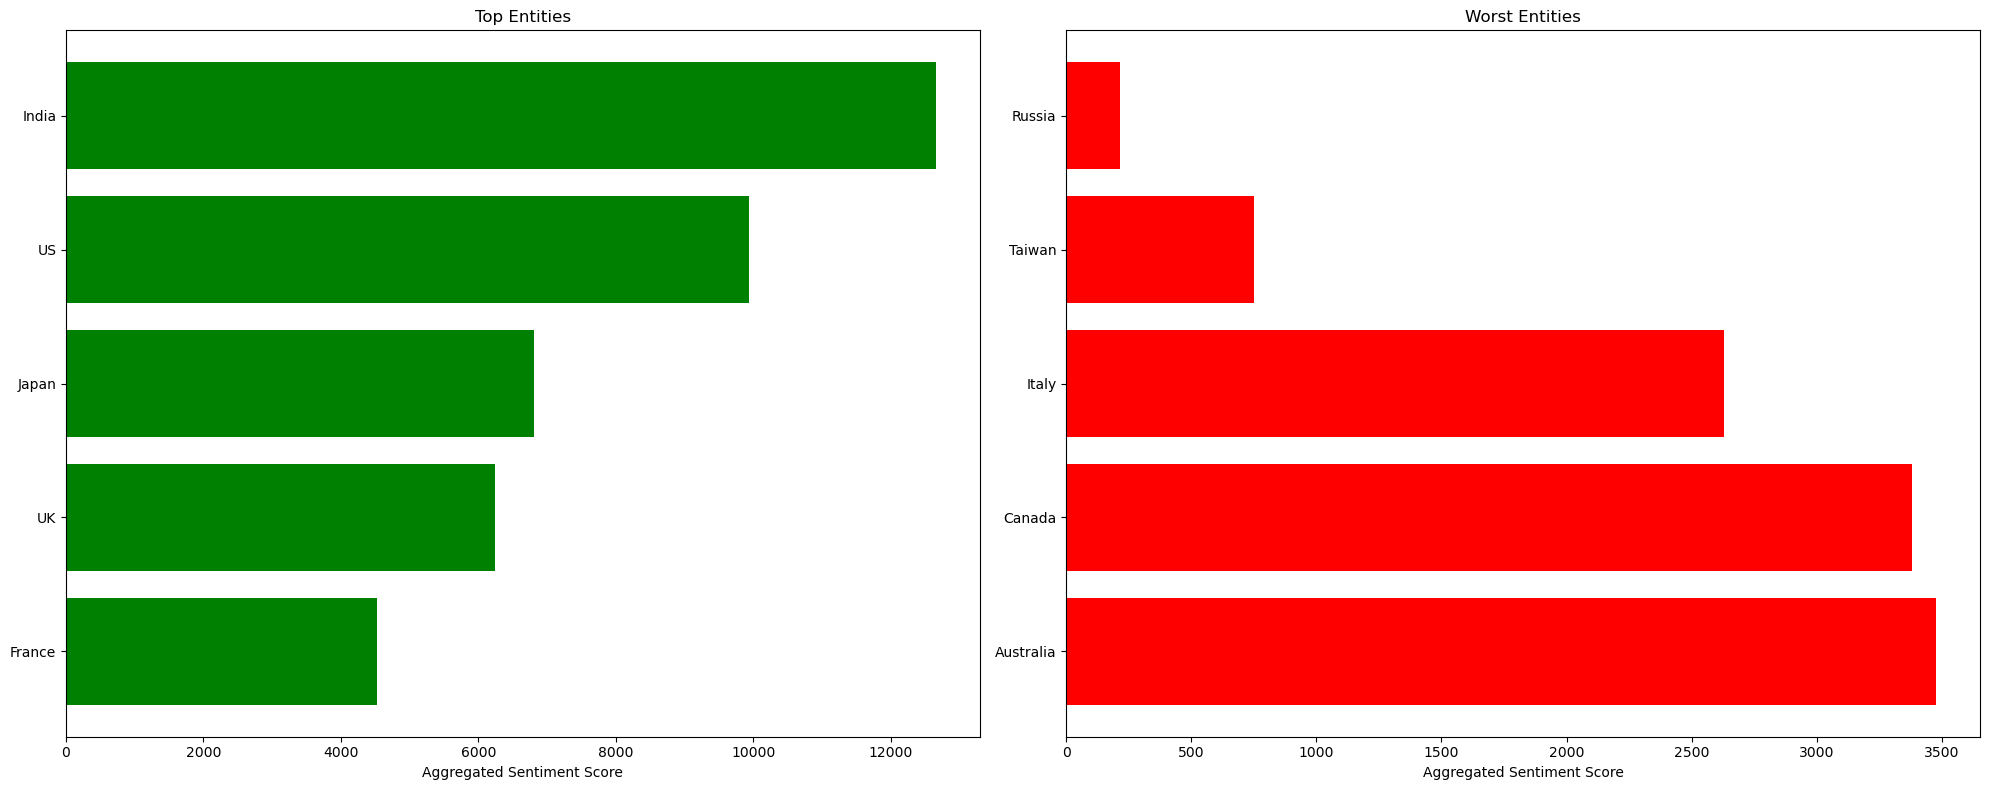

In [57]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities' 
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['GPE']
exclude_entities = ['PRNewswire']
top_n = 5
min_count = 5000


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

- By country, India, the US, Japan, etc., scored high, while Russia　and Taiwan　scored low. However, even in the Worst Entities, there are positive scores, indicating that when a country is mentioned, on average, the sentences are positive.
- This falls somewhat outside the scope of the main purpose of this assignment, so a detailed analysis is omitted

## 6. Sentiment by Person

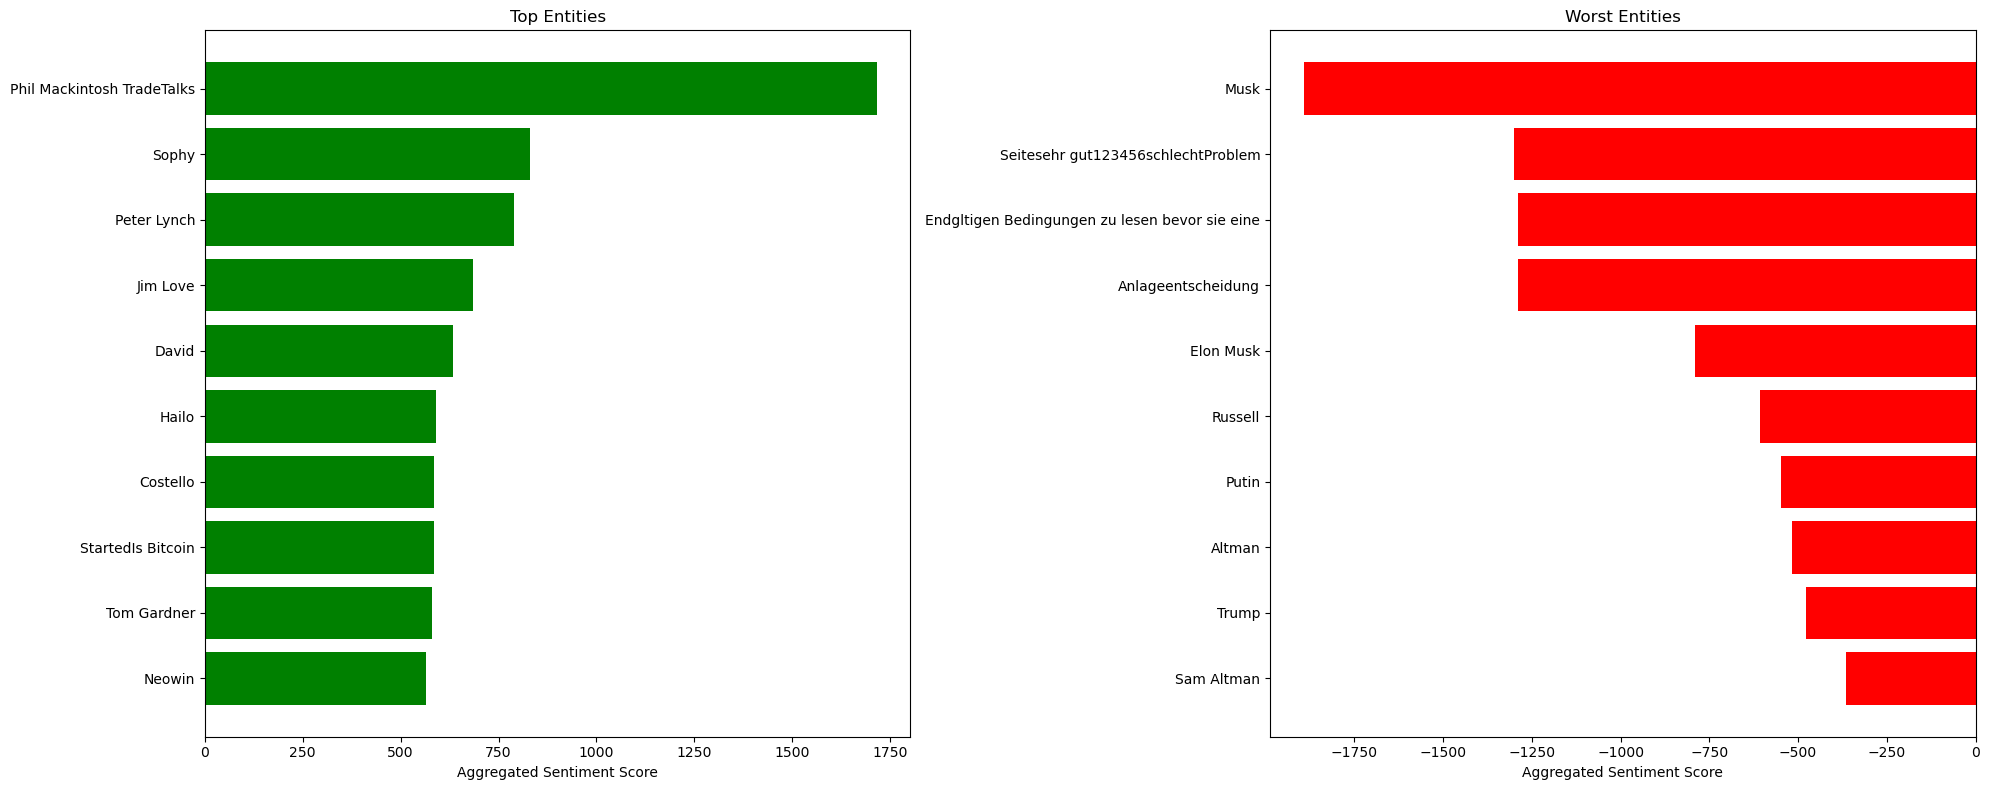

In [58]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities' 
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['PERSON']
exclude_entities = ['AdvertisingAt Gray', 'CaptioningAudio DescriptionAt', 'CaptioningAudio', 'Multicloud', 'Bing']
top_n = 10
min_count = 400


plot_top_worst_entities(
    df=df_merged,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

- TradeTalks Phil Mackintosh and Peter Lynch are individuals related to investment, showing a high interest in investing in AI stocks. 
- Sophy is presumed to be Sony's AI racing game Gran Turismo Sophy, indicating a high interest in the application of AI in games as well. 
- On the negative side, names like Elon Musk, Putin, Sam Altman, and Trump are observed(some are not for AI).
- For AI, as for key figures in AI, Sam Altman and Elon Musk are notable. The sentiment towards these individuals is negative, requiring close attention to discussions related to regulation and their statements.
-  This falls somewhat outside the scope of the main purpose of this assignment, so a detailed analysis is omitted

## 7. Sentiment by Industry

In [59]:
# Adjust data to use funtions
entity_col = 'entities_manual' 
df_merged_manual = df_merged.copy()
df_merged_manual['entities'] = df_merged_manual['entities_manual']

### Manually Added Entities Overview

In [60]:
# Manually added entities

# Count entities by type
entity_types = ['IND', 'JOB', 'TECH']
top_n = 100

top_entities_df = count_top_entities(df_merged_manual['entities_manual'], entity_types, top_n)
top_entities_df

IND                                   JOB  \
0                  Software (88018)                       Analyst (14105)   
1                 Financial (56239)                      Professor (8344)   
2                Healthcare (51707)                         Editor (7973)   
3                    Energy (41140)                      Scientist (4548)   
4                 Education (31711)                         Writer (4336)   
5                Government (30855)                       Engineer (3212)   
6                   Finance (26946)                        Athlete (2336)   
7             Manufacturing (25890)                       Designer (1812)   
8                University (25307)                        Teacher (1404)   
9                  Consumer (22120)                         Artist (1004)   
10                    Legal (21254)                       Architect (998)   
11                     Game (20688)                  Data Scientist (973)   
12                   Retail (20578)                 Product Manager (719)   
13                   Gaming (20119)                    AI Developer (521)   
14                 Hardware (19808)               Software Engineer (416)   
15            Cybersecurity (19014)              Research Scientist (409)   
16               Industrial (18947)              Software Developer (393)   
17            Entertainment (18165)                        Educator (360)   
18              Engineering (18020)                        Lecturer (303)   
19                   Sports (17941)                            Chef (270)   
20                   School (17635)               Financial Adviser (261)   
21                Insurance (17000)               Financial Analyst (252)   
22               Automotive (16520)                       Physicist (173)   
23             Social Media (15420)       Machine Learning Engineer (153)   
24                 Robotics (15269)                 Project Manager (152)   
25                      Law (15124)              Research Associate (129)   
26                     Bank (14908)                    Data Analyst (128)   
27               Blockchain (11046)          Financial Professional (122)   
28                      Art (10846)                      Copywriter (116)   
29           Transportation (10817)                        Caregiver (93)   
30               Consulting (10680)                          Artisan (70)   
31                  Defense (10408)                    Data Engineer (63)   
32               Real Estate (9060)                        Carpenter (61)   
33             Semiconductor (8523)                    Web Developer (58)   
34                  Material (8154)               Operations Manager (55)   
35               Agriculture (7586)                   Media Producer (49)   
36              Construction (7459)                        Librarian (48)   
37                   Fintech (7151)          Healthcare Professional (44)   
38                 Logistics (6497)         Cybersecurity Specialist (44)   
39                E-commerce (6371)                Account Executive (32)   
40           Cloud Computing (5974)                  Service Manager (31)   
41               Health Care (5783)                 Business Manager (30)   
42                   Fashion (5227)                     Veterinarian (29)   
43                    Mining (4835)                  IT Professional (28)   
44              Web Services (4671)               Sales Professional (26)   
45            Pharmaceutical (4667)                       Biochemist (25)   
46      Software Development (3880)                 Graphic Designer (24)   
47                Publishing (3863)           Marketing Professional (23)   
48                 Utilities (3817)  Customer Service Representative (22)   
49  Research and Development (3751)              Dental Professional (21)   
50                  Chemical (3732)                Care Professional (19)   
51                   Biotech

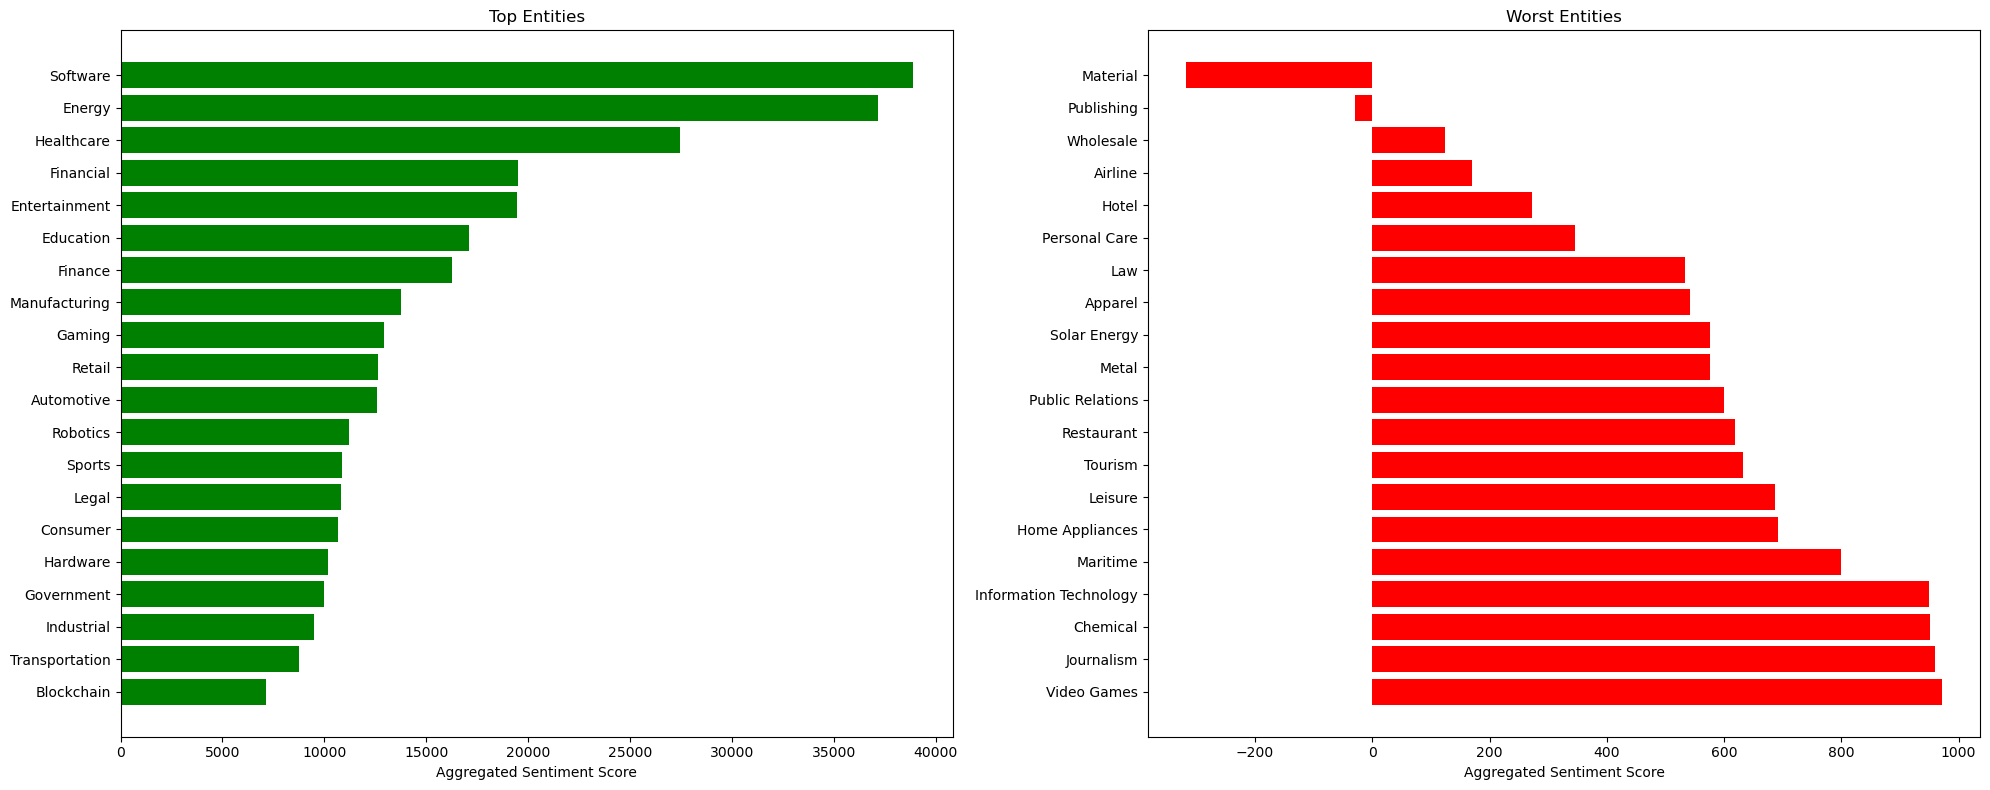

In [61]:
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['IND']
exclude_entities = []
top_n = 20
min_count = 500


plot_top_worst_entities(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

Due to overlapping analysis between Topics and Jobs, detailed comments will be omitted.

## 8. Sentiment by Job

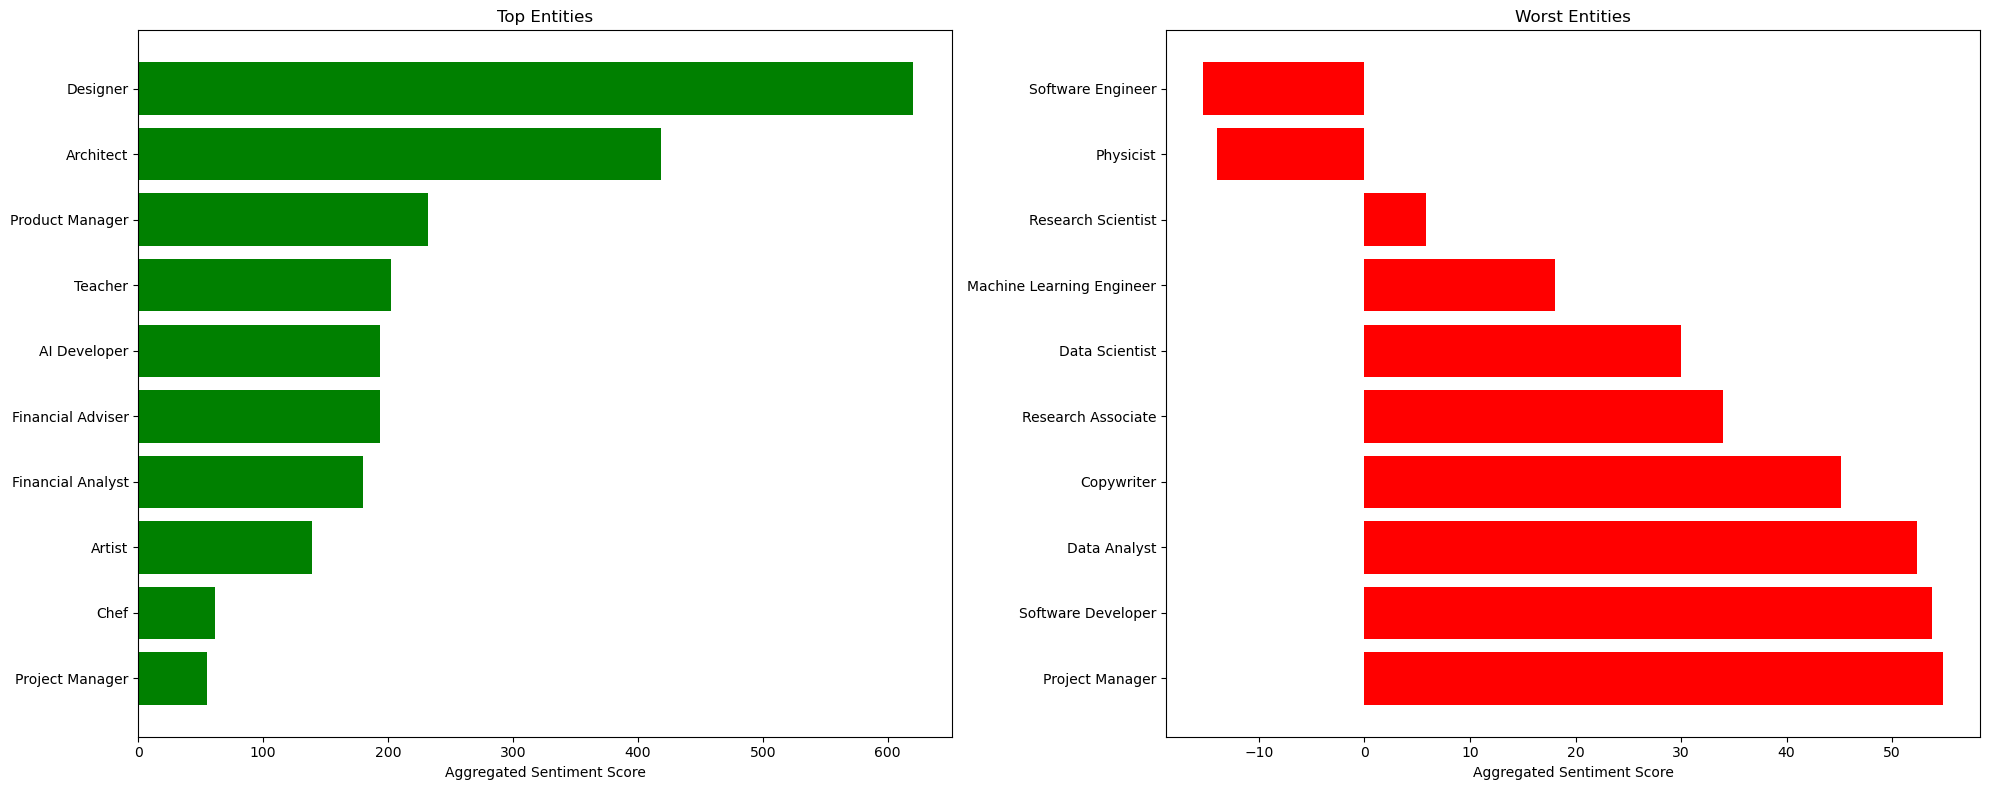

In [62]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities_manual' 
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['JOB']
# Exclude words that are too general or repetitive. Exclude 'Editor' and 'Writer' as they appear frequently in the context of news articles.
exclude_entities = ['Analyst', 'Scientist', 'Engineer', 'Editor', 'Writer', 'Educator','Professor','Lecturer', 'Athlete', 'Financial Professional']
top_n = 10
min_count = 100

plot_top_worst_entities(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

In [63]:
# What happend to Desinger?
df_ai = filter_rows_by_words(df_merged_manual, 'sentence', 'AI')
filter_df_by_entity_and_type(df_ai, 'Designer', 'JOB')[['year_month','sentence','sentiment_score']].iloc[19]

year_month                                                                                                                                                                    2023-06
sentence           The resulting algorithm allows the designer to optimize engineering constraints while maintaining their text-based stylistic prompts to the generative AI process.
sentiment_score                                                                                                                                                              0.624653
Name: 55115, dtype: object

In [64]:
# What happend to Data Scientist?
filter_df_by_entity_and_type(df_ai, 'Data Scientist', 'JOB')[['year_month','sentence','sentiment_score']].iloc[42]

year_month                                                                                 2023-10
sentence           With Signal AI you don't need to be a data scientist to unlock the power of AI.
sentiment_score                                                                          -0.668956
Name: 364214, dtype: object

Comments for Sentiment Analysis by Jobs
- Jobs with the highest sentiment include roles that require creativity, such as Designers, Artists and Chef as well as positions involving interaction with people, like Teachers, Financial Advisors, and Product/Project Managers. 
- Conversely, jobs with the worst sentiment are often technical or code-based, such as Software Engineers, MLEs, and Data Scientists. Interestingly, AI Developer ranks high in sentiment, suggesting those who create AI could thrive. 
- As indicated by news examples, efficiently utilizing AI as a tool to enhance work and add value may turn individuals into assets who can leverage AI, rather than being replaced by it.

## 9. Sentiment by Technology

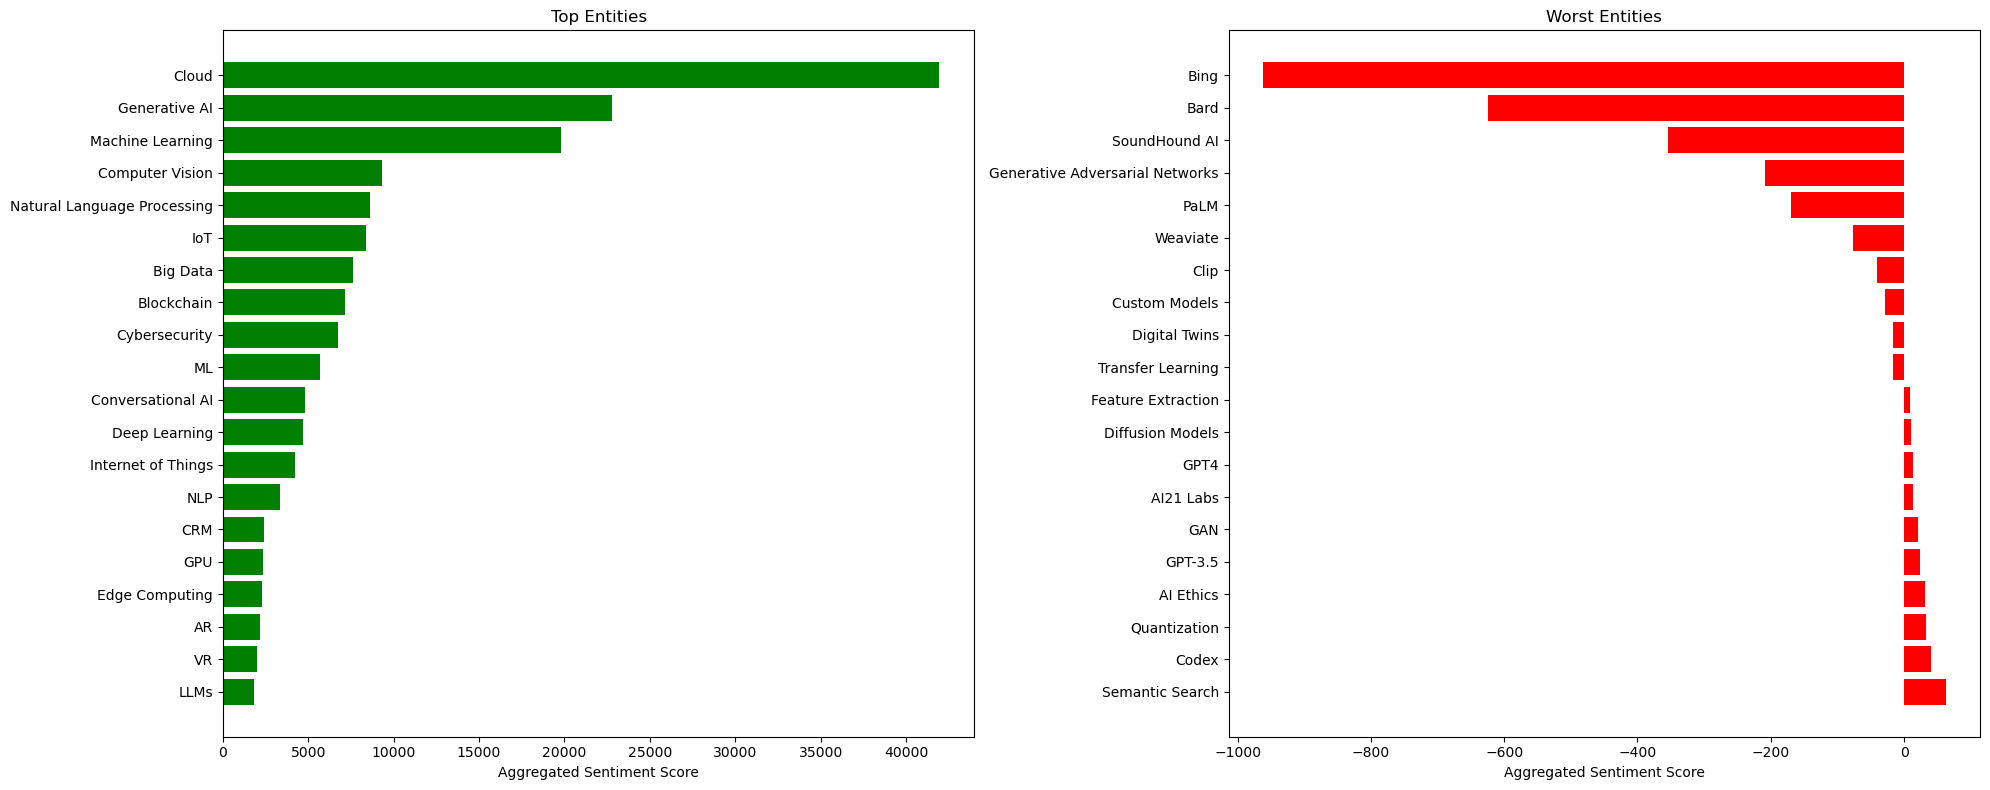

In [66]:
# Define the DataFrame columns for entities and sentiment scores
entity_col = 'entities_manual' 
sentiment_col = 'sentiment_score'

# Set the aggregation method, entity types, entities to exclude,　the number of top/worst entities to display　and the minimum count for an entity to be included.
aggregation_method = 'sum'
entity_types = ['TECH']
exclude_entities = []
top_n = 20
min_count = 100


plot_top_worst_entities(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

Anticipating a change in frequently occurring words before and after the introduction of ChatGPT, the results for each period will be displayed separately for the following periods.

In [65]:
# Split df_merged into df_old(before ChatGPT) and df_new(after ChatGPT) based on the date
df_old = df_merged_manual[df_merged['date'] <= '2022-11-29']
df_new = df_merged_manual[df_merged['date'] >= '2022-11-30']

df_merged_manual.shape, df_old.shape, df_new.shape

((3537608, 10), (1464680, 10), (2072928, 10))

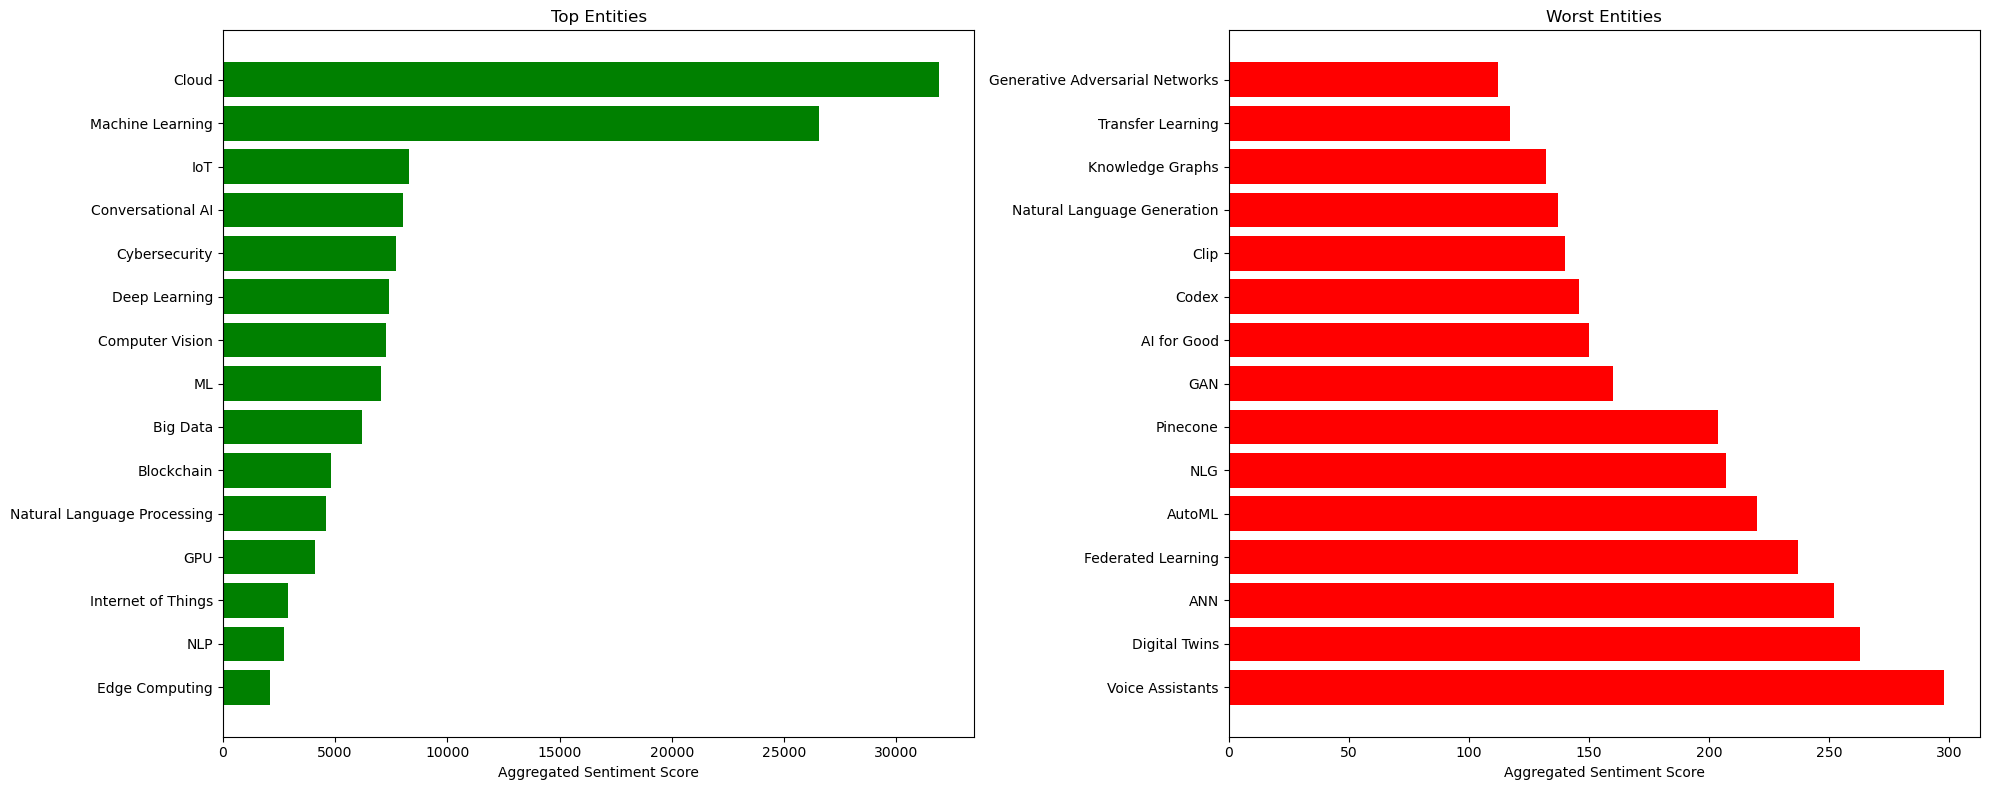

In [67]:
aggregation_method = 'count'

top_n=15

# Before ChatGPT
plot_top_worst_entities(
    df=df_old,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

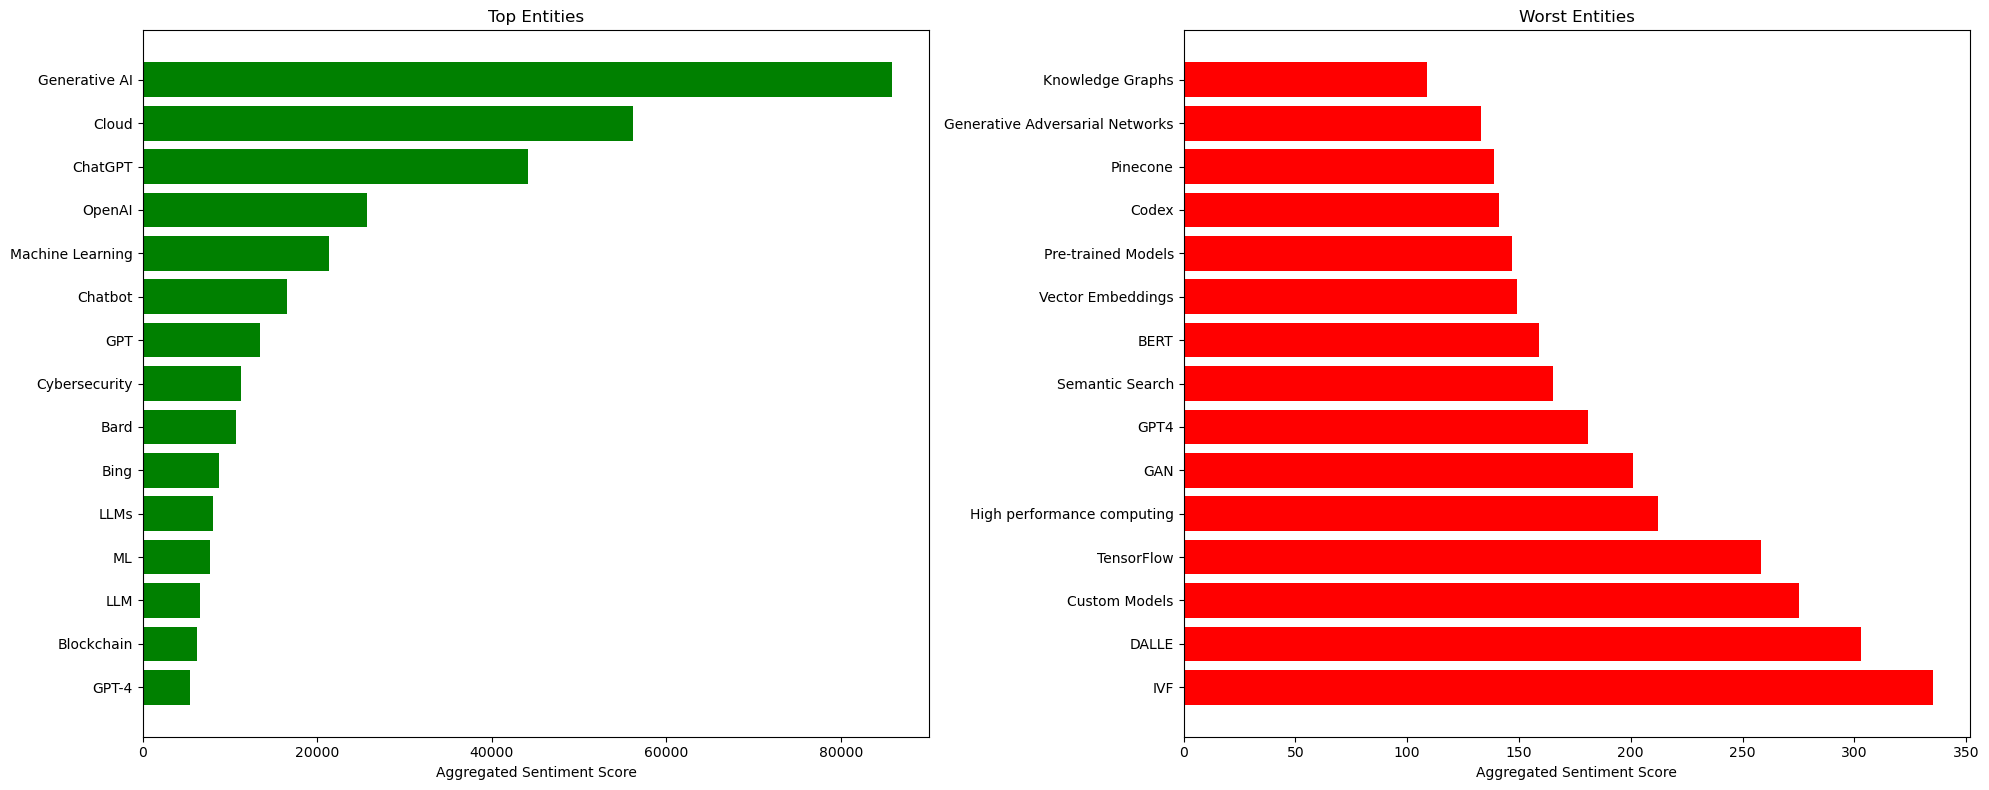

In [68]:
aggregation_method = 'count'

# After ChatGPT
plot_top_worst_entities(
    df=df_new,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

- Before the introduction of ChatGPT, topics such as Cloud, IoT, Cybersecurity, Machine Learning, and Deep Learning were at the forefront. There were mentions of Conversational AI, but not as many in terms of count. 
- After the introduction of ChatGPT, there has been a significant increase in mentions of topics related to Generative AI, including ChatGPT, Bard, Bing, and LLMs, in the news. The fact that specific service names are ranking at the top is interesting. 
- Cloud and Cybersecurity continues to receive high attention, suggesting that it remains an important technology.

## 10. Sentiment by NEW Technology

In [69]:
# Only new technology(Relared to GenAI, mainly around 2023~)

df_techlist = pd.read_csv('/Users/daichiishikawa/Desktop/UChicago Class/NLP/Final Project/Technology.csv')
df_techlist.head()

technology  flg_new
0          GenAI        1
1         Gen AI        1
2  Generative AI        1
3            GPT        1
4         GPT3.5        1

In [70]:
df_techlist_old = df_techlist[df_techlist['flg_new'] == 0]
df_techlist_old.head()

technology  flg_new
15                   Cloud        0
17        Machine Learning        0
18                      ML        0
19           Deep Learning        0
20  Reinforcement Learning        0

In [71]:
techlist_old = df_techlist_old['technology'].tolist()

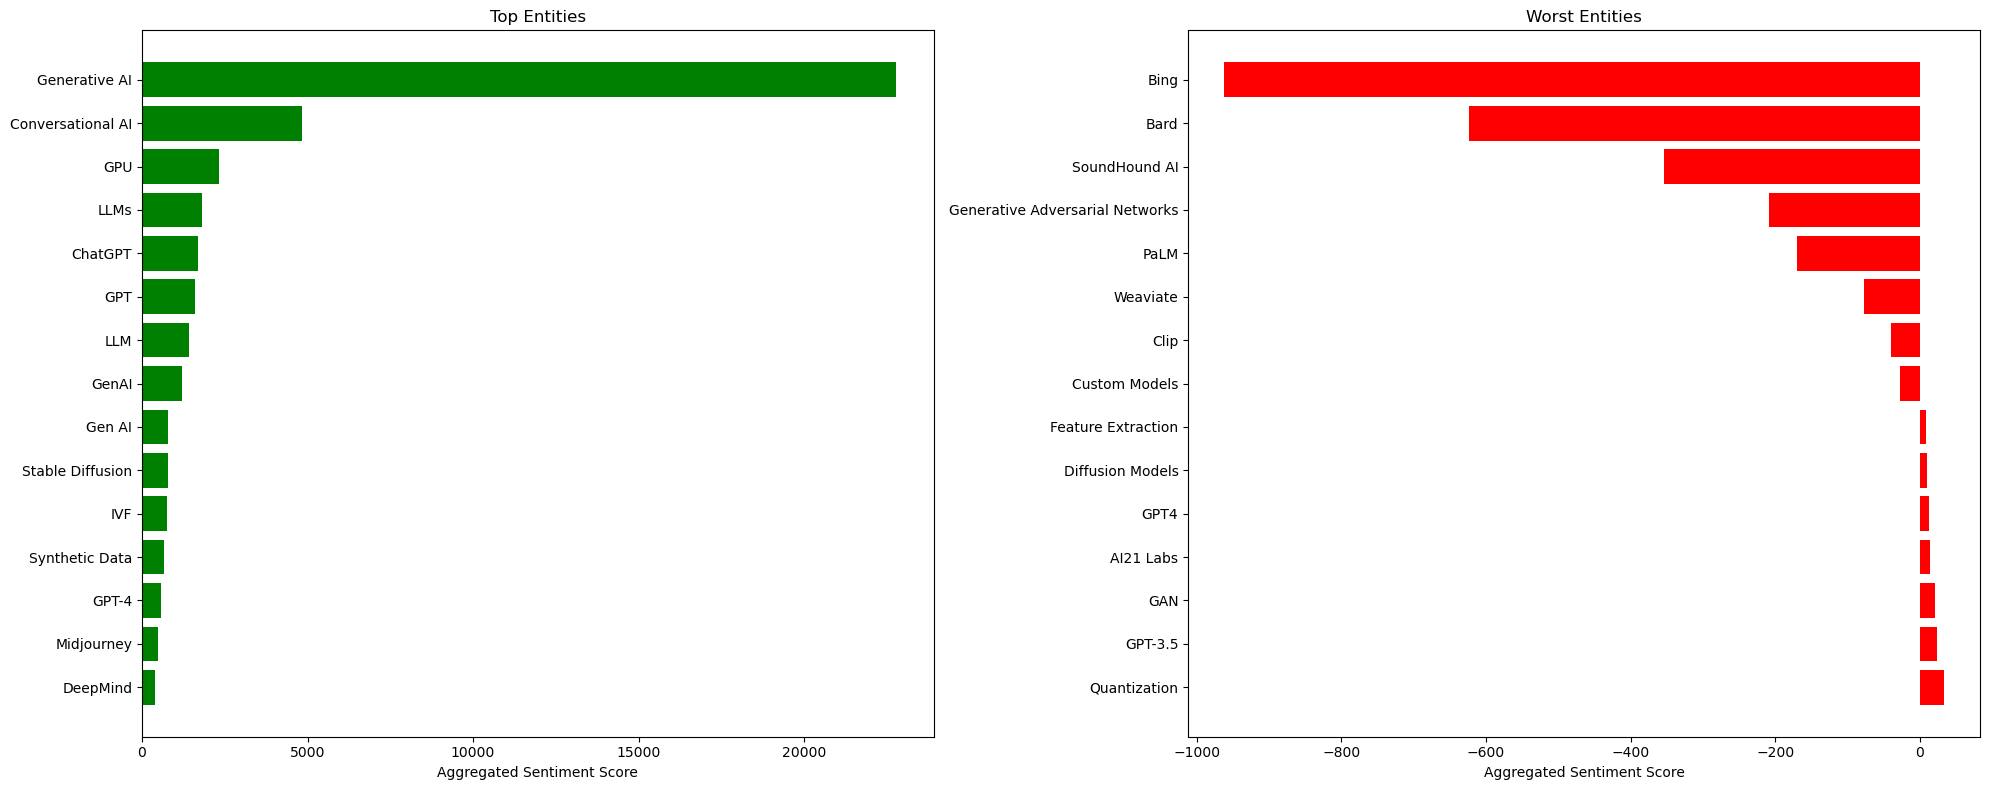

In [72]:
# Only new technology　- sentiment sum

aggregation_method = 'sum'

exclude_entities = techlist_old

plot_top_worst_entities(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

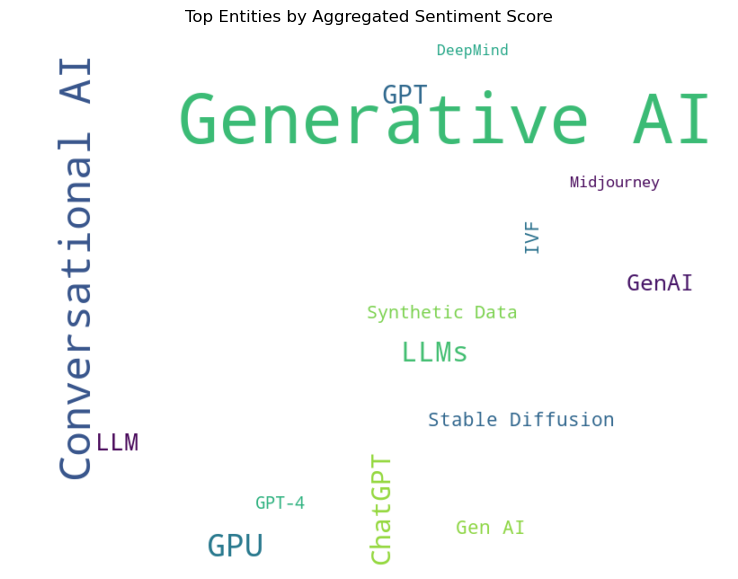

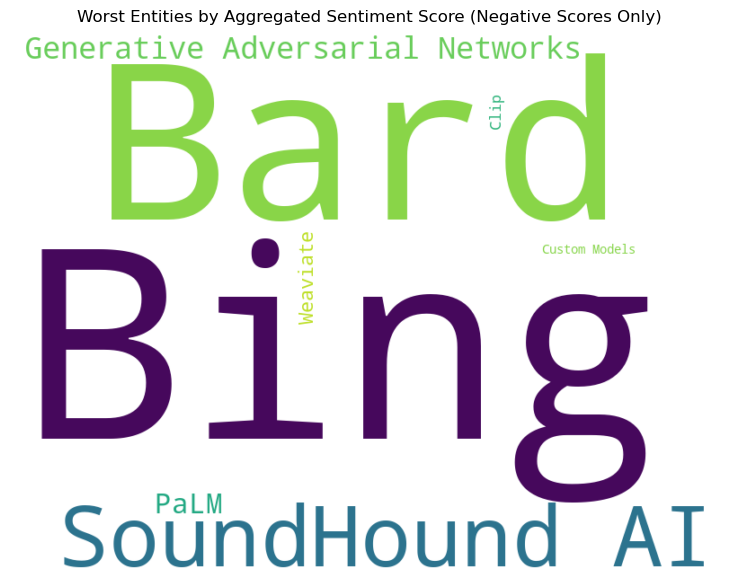

In [73]:
aggregation_method = 'sum'

plot_top_worst_entities_wordcloud(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

In [79]:
# Sentiment for Bard and Bing
filter_df_by_entity_and_type(df_merged_manual, 'Bard', 'TECH')[['year_month','sentence','sentiment_score']].sort_values(by='sentiment_score').head(2)

year_month  \
1982440    2023-05   
3746773    2023-02   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
1982440                                                       Also Read Google expands Bard in response to ChatGPT challenge While there would be many benefits from ending repetitive dangerous and unpleasant work we already know that unemployment is strongly associated with adverse health outcomes and behaviours including harmful use of alcohol and illicit drugs being overweight and having lower self-rated quality of life and health and higher levels of depression and suicide risk the experts explained.   
3746773  After Google's Bard AI Microsoft's AI-Powered Bing Also Making Factual Errors Report OPEN IN APPJagran LogoShare MarketTop DealsWeb StoriesAndroidSearchMenuNewsTechnologyMore In NewsPolitical Storm In Maha Over Assam Govt's Claims On Jyotirlinga Oppn Attacks BJP Says 'Gods Taken Away' India'Akin To Suppressing Public Voice' Arvind Kejriwal On Income Tax Survey At BBCIndiaDelhi Road Rage Man Stabbed To Death In Nangloi Family Blames Cops 3 DetainedIndiaTax Survey At BBC Continues For Second D...   

         sentiment_score  
1982440        -3.206933  
3746773        -3.206933

In [84]:
# Sentiment for SoundHound AI
filter_df_by_entity_and_type(df_merged_manual, 'SoundHound AI', 'TECH')[['year_month','sentence','sentiment_score']].sort_values(by='sentiment_score').head(3)

year_month  \
5051459    2023-08   
6878356    2023-09   
1033596    2022-11   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sentence  \
5051459  SOUNDHOUND AI INC. CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS In thousands Unaudited Six Months EndedJune 30 2023 2022 Cash flows from operating activities Net loss 48301 55771 Adjustments to reconcile net loss to net cash used in operating activities Depreciation and amortization 1411 2269 Stock-based compensation 13947 10327 Change in fair value of derivative and warrant liability 606 Non-cash interest expense 1607 2185 Non-cash lease expense 1714 1545 Loss on debt extinguishment 837 ...   
6878356                                                                                                                                                                                                                                                                                                                           Even the most pessimistic price target implies an upside potential of more than 65.Is Wall Street rightIt's possible that these three bullish analysts are dead wrong about SoundHound AI.   
1033596                                                                                                                                                                                                                                                    Accumulated deficit 471422 386729 Total stockholders deficit 14377 343237 Total liabilities redeemable convertible preferred stock and stockholders deficit 63841 49203 SOUNDHOUND AI INC. CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS AND COMPREHENSIVE LOSS   

         sentiment_score  
5051459        -3.008923  
6878356        -2.975136  
1033596        -2.942396

In the sum sentiment, there's a risk of missing the latest technologies due to words with high word counts. Therefore, the average sentiment will also be considered below.

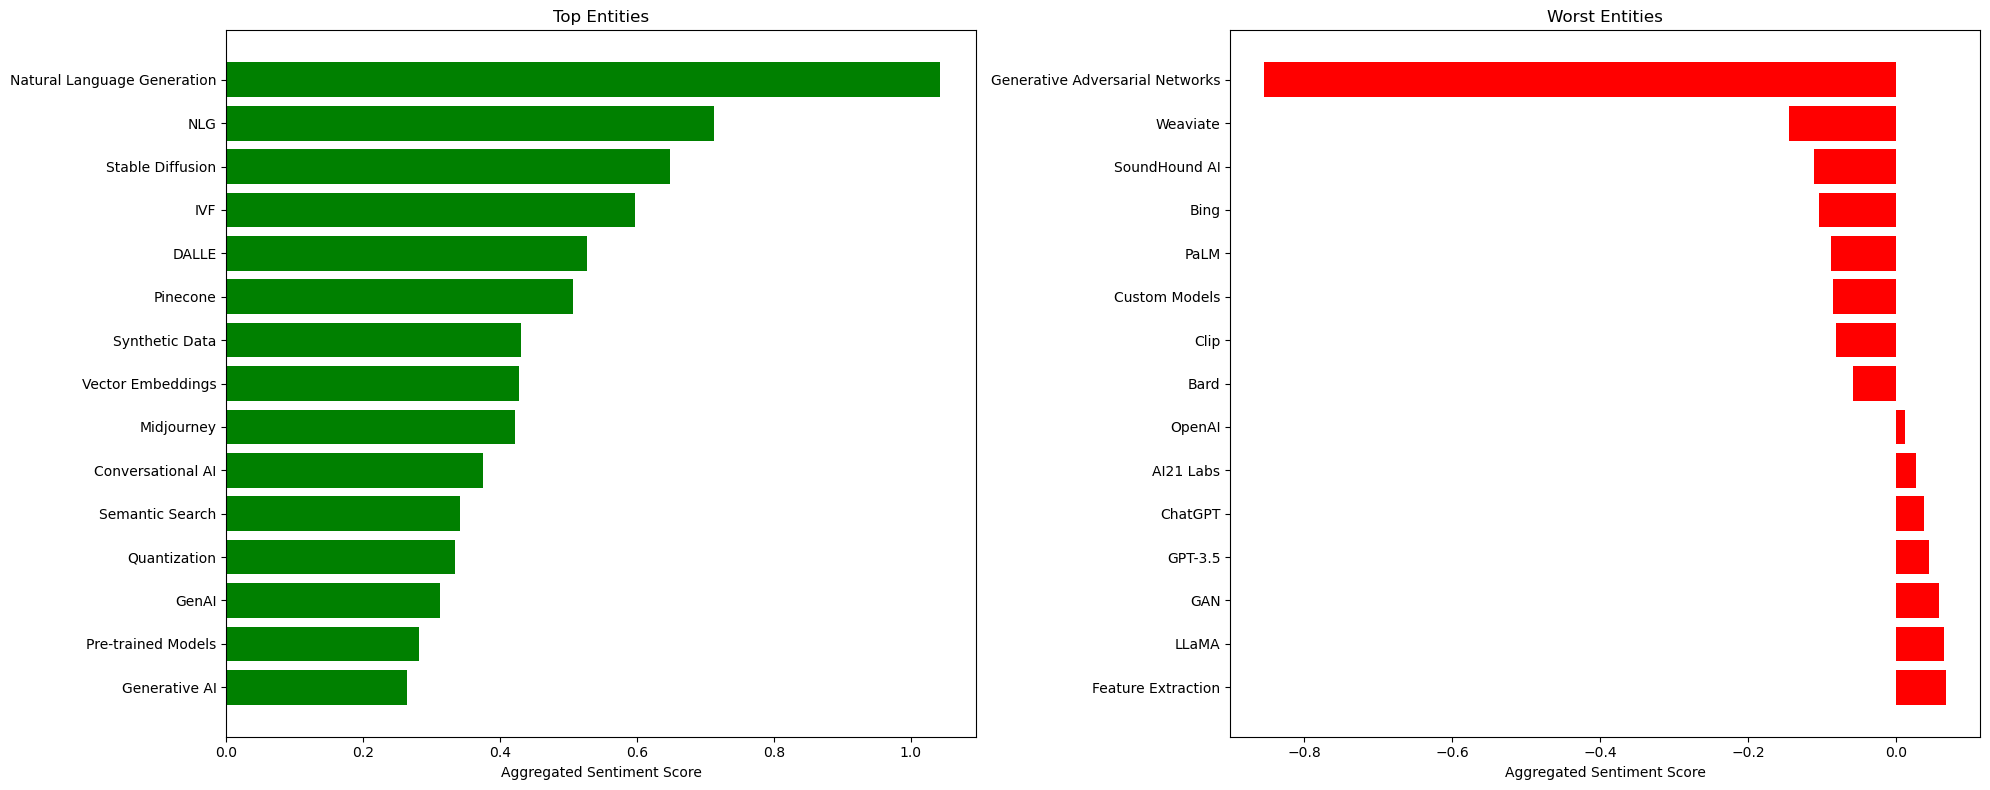

In [74]:
# Only new technology - sentiment mean

aggregation_method = 'mean'

plot_top_worst_entities(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

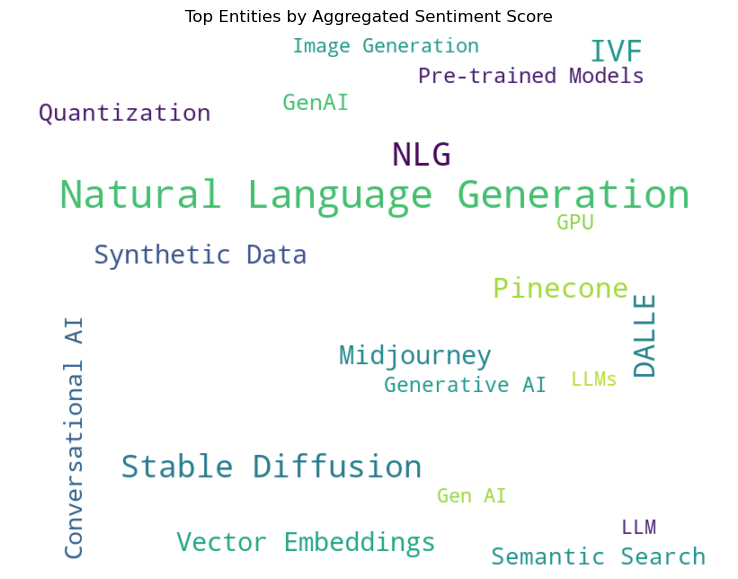

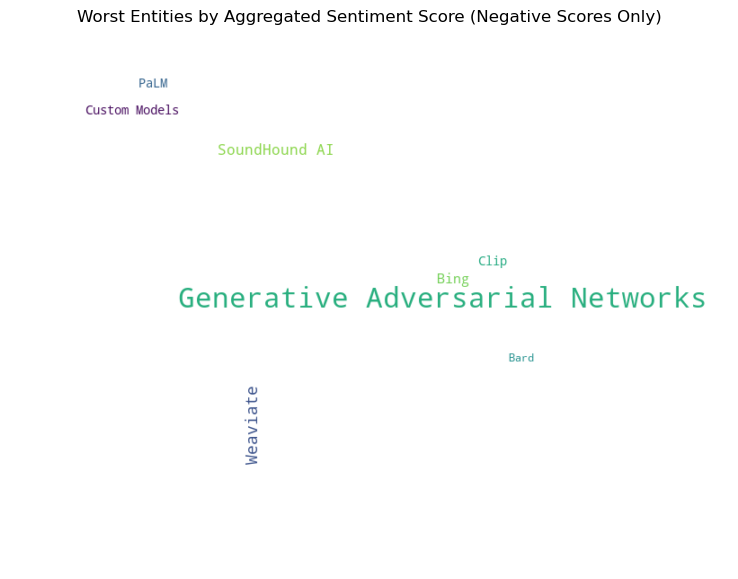

CPU times: user 1min 18s, sys: 7.19 s, total: 1min 25s
Wall time: 1min 29s


In [274]:
aggregation_method = 'mean'

plot_top_worst_entities_wordcloud(
    df=df_merged_manual,
    entity_col=entity_col,
    sentiment_col=sentiment_col,
    aggregation=aggregation_method,
    entity_types=entity_types,
    exclude_entities=exclude_entities,
    top_n=top_n,
    min_count=min_count
)

Comments for Sentiment Analysis by New Tech
- There are categories that showed a positive sentiment include 1. Text Generation (NLG, LLMs, Conversational AI), 2. Image Generation (DALL·E, Stable Diffusion, Midjourney), 3. Chip (GPU), and 4. Search and Data Processing for GenAI (Vector Embeddings, IVF, Semantic Search, Pinecone (Vector Database Service), Quantization). 
- On the other hand, Bard and Bing showed notable negative sentiments due to its factual errors.

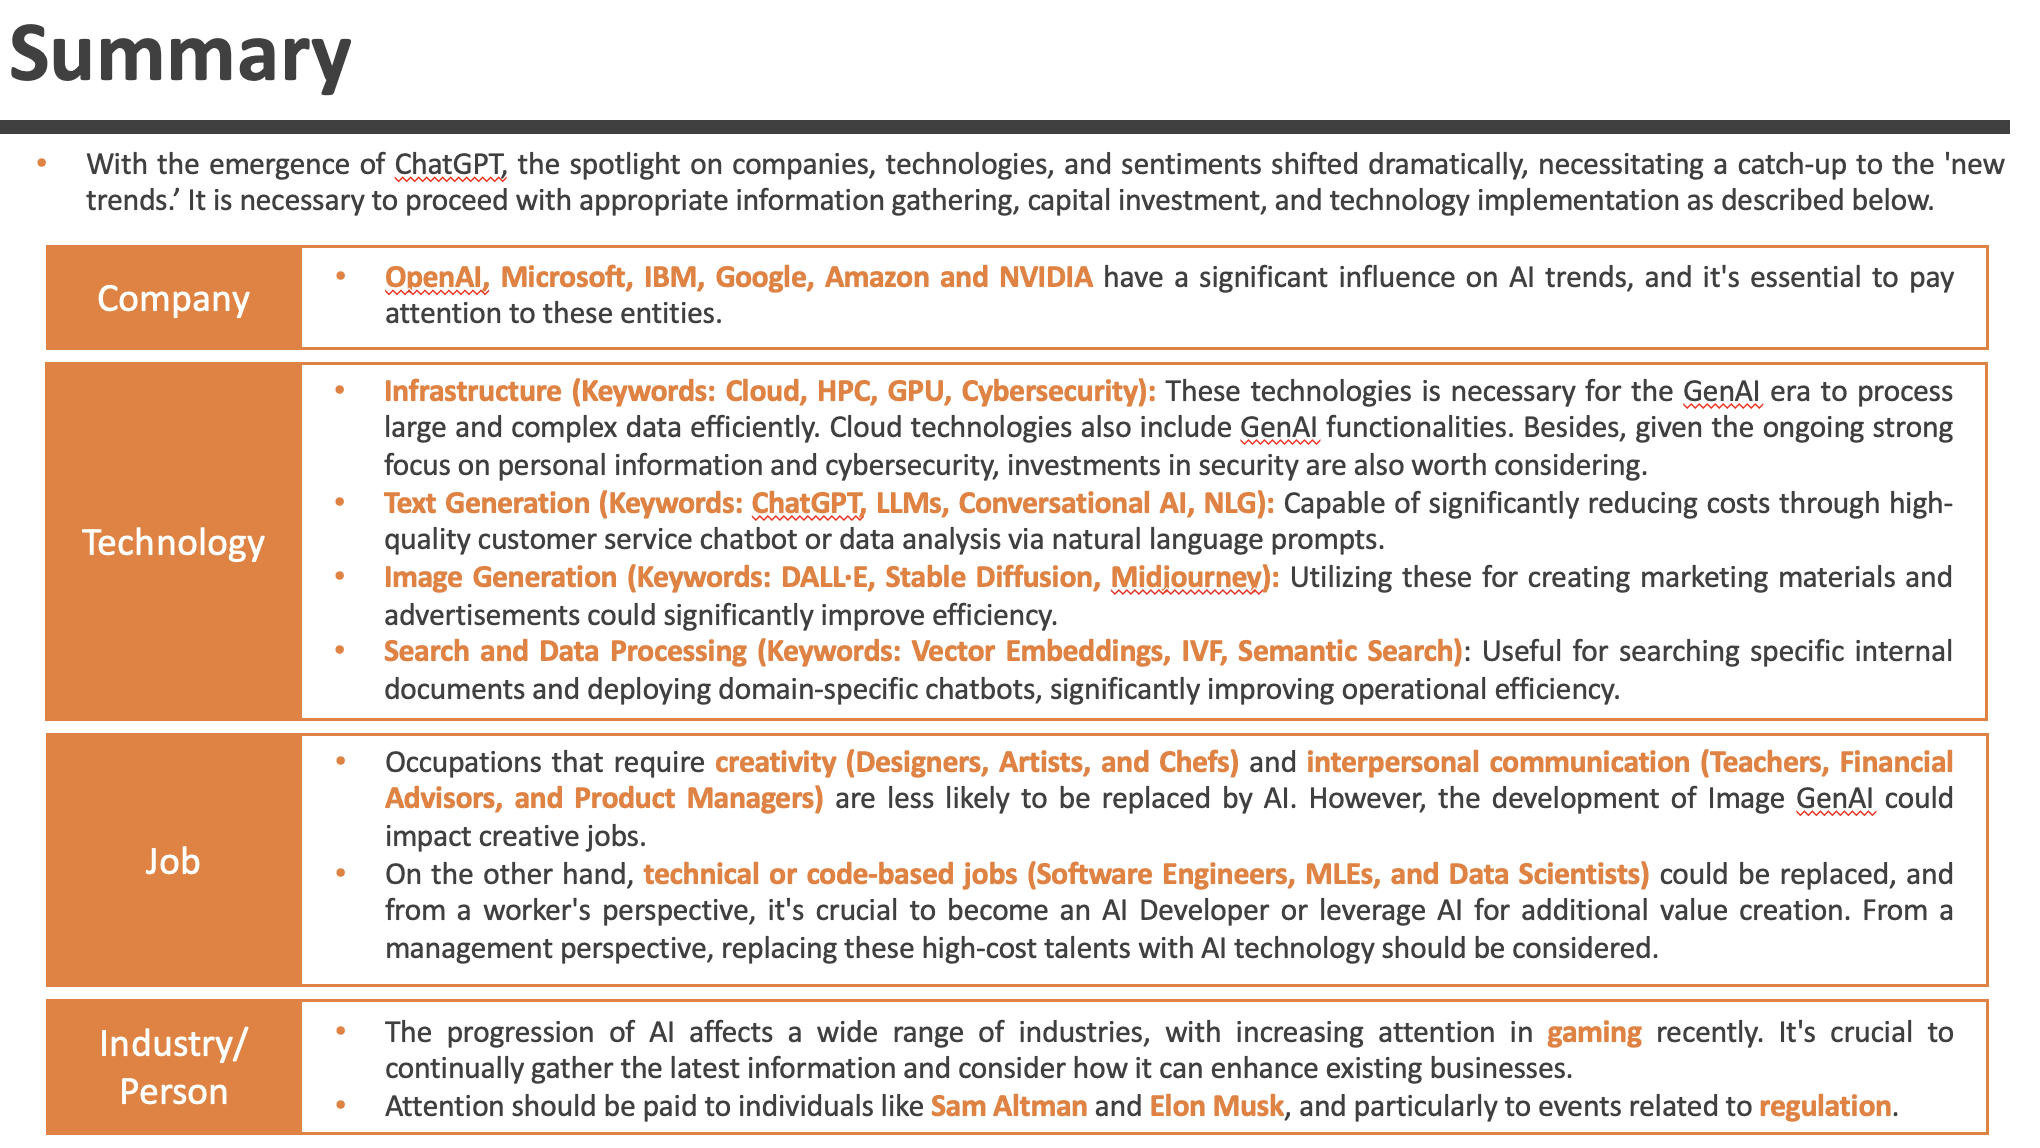